In [26]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp, solve_bvp
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
%config InlineBackend.figure_format = 'retina'
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 40
from scipy.interpolate import interp1d
from scipy.optimize import least_squares, minimize

In [27]:
NORMALIZATOR = 1e-10

In [28]:
def generate_fishing_grounds(n_grounds = 10, x_max = 100, y_max = 100):
    return np.random.rand(n_grounds, 2) * np.array([x_max, y_max])

In [29]:
def generate_ships(n_ships = 10, x_max = 100, y_max = 100):
    return np.random.rand(n_ships, 2) * np.array([x_max, y_max])

In [30]:
def generate_ships_at_harbor(h, n_ships = 10):
    """
    Returns an n_ships x 2 array of ships at the harbor h with gaussian noise
    """
    # return np.array([h + np.random.normal(0, 1, 2) for _ in range(n_ships)])
    return np.array([h for _ in range(n_ships)])

In [31]:
def calculate_ship_distance_from_grounds(ships, grounds):
    return np.linalg.norm(ships[:, np.newaxis] - grounds, axis=2)

In [32]:
def d_matrix(ships, grounds):
    # Vectorized difference calculation
    differences = grounds - ships[:, np.newaxis]
    distances = np.linalg.norm(differences, axis=2, keepdims=True)
    return differences / (distances + NORMALIZATOR)

In [33]:
def ship_ground_gaussians(ships, grounds, alpha, b=1, c=0):
    distances = np.linalg.norm(ships[:, np.newaxis] - grounds, axis=2)
    return b*np.exp(-alpha * distances**2) + c

In [34]:
def calculate_ship_distance_from_ships(ships):
    return np.linalg.norm(ships[:, np.newaxis] - ships, axis=2)

In [35]:
def harbor_attraction(U, ships, h):
    diff = h - ships
    diff_norm = np.linalg.norm(diff, axis=1, keepdims=True)
    return U[:, -2, np.newaxis] * (diff / (diff_norm + NORMALIZATOR))

In [36]:
def attraction_matrix(U, G, D, F):
    F_reshaped = F.reshape(1, -1, 1)
    return U[:, :-2, None] * G[:, :, None] * D * F_reshaped

In [37]:
def calculate_F_prime(t, F, C, rate):
    C_sum = np.sum(C, axis=0)
    return -rate * F * C_sum

In [38]:
def calculate_S_matrix(A, H):
    return np.sum(A, axis=1).reshape(-1, 2) + H

In [39]:
def calculate_x_prime(U, S):

    # Reshape U[:,-2] to have an extra dimension
    U_reshaped = U[:,-1].reshape(-1, 1)

    return U_reshaped * S

Take orthogonal unit vector to s_i, namely r_i

inner product that with p_i, take abs value

find minimum of that <r_i, p_i>

Penalize ||u_i,j(t-1) - u_i,j(t)||

so minimize over u_ij for all i, j <r_i, p_i> + ||u_i,j(t-1) - u_i,j(t)||

In [40]:
def Dxs_matrix(x, grounds, ships, G, U, F, distances, differences, alpha, h):
    F_reshaped = F.reshape(1, -1, 1)
    
    # This will have shape (N, K, 1)
    outer_scalar = (U[:, :-2, None] * G[:, :, None] * F_reshaped) / (distances + NORMALIZATOR)
    
    # Calculate the inner scalar term, reshaping it to (N, K, 1, 1) to broadcast with the outer product
    inner_scalar = (alpha + 1 / (distances[..., 0]**2 + NORMALIZATOR)).reshape(*distances.shape[:2], 1, 1)
    
    # Compute the outer products
    outer_products = differences[..., np.newaxis] * differences[..., np.newaxis, :]
    
    # Identity matrix needs to be (1, 1, 2, 2) to broadcast correctly
    I_2 = np.eye(2).reshape((1, 1, 2, 2))

    # print((inner_scalar * outer_products - I_2).shape)
    
    # The term_inside_summation should have shape (N, K, 2, 2)
    term_inside_summation = outer_scalar[..., np.newaxis] * (inner_scalar * outer_products - I_2)
    
    # Sum over the second axis, corresponding to summing over 'j' (the grounds)
    # This will result in shape (N, 2, 2)
    DxS = np.sum(term_inside_summation, axis=1)
    return DxS


In [41]:
def calculate_p_f_prime(t, pf, C, rate):
    C_sum = np.sum(C, axis=0)
    return rate * pf * C_sum

In [42]:
def calculate_p_prime(p, pf, S, U, Dxs, ship_differences, differences, distances, rate, sigma, beta, epsilon):
    # Shape: (N, 2, 2), the outer product of S
    S_outer = S[:, :, np.newaxis] * S[:, np.newaxis, :]

    # Shape: (N,), the inner product of S with the differences
    S_norm = (np.linalg.norm(S, axis=1))

    # Shape: (N, 2, 2)
    S_outer /= (S_norm[:, np.newaxis, np.newaxis]**2 + NORMALIZATOR)
    # print(S_outer.shape)

    # Shape: (N, 1, 1)
    U_scalar = U[:, -1][:, np.newaxis, np.newaxis]

    # Shape: (N, 2, 2)
    I_2 = np.eye(2).reshape((1, 2, 2))

    # Shape: (N, 2, 2)
    first_term = U_scalar * (I_2 - S_outer)

    # Shape: (N, 2, 2)
    dxs = (Dxs / (S_norm[:, np.newaxis, np.newaxis] + NORMALIZATOR))

    # Shape: (N, 2, 1)
    second_term = dxs @ p[:, :, np.newaxis]
# 
    # print(first_term.shape, second_term.shape)

    # Shape: (N, 2, 1)
    combined = np.matmul(first_term, second_term)

    # Shape: (N, N, 2)
    term_inside_summation = ship_differences / (np.linalg.norm(ship_differences, axis=1)**2 + epsilon)**2

    # Shape: (N, 2)
    distance_sum = np.sum(term_inside_summation, axis=1)

    # Shape: (N, K, 2)
    inner_sum = pf[:,np.newaxis] * np.exp(-sigma * distances**2) * differences

    # Shape: (N, 2)
    sum_term = np.sum(inner_sum, axis=1) * 2*sigma*rate

    return (4 * beta * distance_sum) - sum_term - combined.squeeze()

    

In [43]:
# OUTDATED
def ode(t, y, params):
    alpha, sigma, beta, rate, U, grounds, h, x_size, F_size, p_size, x_shape, p_shape = params
    b = 1
    x = y[:x_size].reshape(x_shape)  # reshape x back to its original shape
    F = y[x_size:x_size+F_size]
    p = y[x_size + F_size: x_size + F_size + p_size].reshape(p_shape)
    pf = y[x_size + F_size + p_size:]

    differences = grounds - x[:, np.newaxis]
    distances = np.linalg.norm(differences, axis=2, keepdims=True)

    ship_diffences = x[:, np.newaxis] - x
    # ship_distances = np.linalg.norm(ship_diffences, axis=2)

    # Calculate D matrix
    D = differences / (distances + NORMALIZATOR)

    # Calculate G matrix
    G = ship_ground_gaussians(x, grounds, alpha, b=b)

    # Calculate Collection matrix
    C = ship_ground_gaussians(x, grounds, sigma, b=b)

    # Calculate A matrix
    A = attraction_matrix(U, G, D, F)

    # Calculate H
    # H = harbor_attraction(U, x, h)


    S = np.sum(A, axis=1).reshape(-1, 2)

    # S = S + H

    S_normal = S / (np.linalg.norm(S, axis=1, keepdims=True) + NORMALIZATOR)

    F_prime = calculate_F_prime(t, F, C, rate)

    x_prime = calculate_x_prime(U, S_normal)
    # print(np.linalg.norm(x_prime, axis=1))

          
    Dxs = Dxs_matrix(x, grounds, x, G, U, F, distances, differences, alpha, h)

    p_prime = calculate_p_prime(p, pf, S, U, Dxs, ship_diffences, differences, distances, rate, sigma, beta)

    pf_prime = calculate_p_f_prime(t, pf, C, rate)

    # print(p_prime)

    # Flatten x_prime and F_prime and concatenate them into a single 1D array
    # return np.concatenate((x_prime.flatten(), F_prime.flatten(), np.ones_like(p_prime).flatten()))
    return np.concatenate((x_prime.flatten(), F_prime.flatten(), p_prime.flatten(), pf_prime.flatten()))

In [44]:
def state(t, y, params):
    U, alpha, sigma, beta, rate, grounds, h, x_size, F_size, x_shape= params
    b = 1
    x = y[:x_size].reshape(x_shape)  # reshape x back to its original shape
    F = y[x_size:]

    differences = grounds - x[:, np.newaxis]
    distances = np.linalg.norm(differences, axis=2, keepdims=True)

    # ship_distances = np.linalg.norm(ship_diffences, axis=2)

    # Calculate D matrix
    D = differences / (distances + NORMALIZATOR)

    # Calculate G matrix
    G = ship_ground_gaussians(x, grounds, alpha, b=b)

    # Calculate Collection matrix
    C = ship_ground_gaussians(x, grounds, sigma, b=b)

    # Calculate A matrix
    A = attraction_matrix(U, G, D, F)

    # Calculate H
    # H = harbor_attraction(U, x, h)


    S = np.sum(A, axis=1).reshape(-1, 2)

    # S = S + H

    S_normal = S / (np.linalg.norm(S, axis=1, keepdims=True) + NORMALIZATOR)

    F_prime = calculate_F_prime(t, F, C, rate)

    x_prime = calculate_x_prime(U, S_normal)

    return np.concatenate((x_prime.flatten(), F_prime.flatten()))

def costate(t, y, params):
    x, F, U, alpha, sigma, beta, epsilon, rate, grounds, h, p_size, pf_size, p_shape = params
    b = 1
    p = y[:p_size].reshape(p_shape)  # reshape x back to its original shape
    pf = y[p_size:]
    x = x.reshape(p_shape)

    differences = grounds - x[:, np.newaxis]
    distances = np.linalg.norm(differences, axis=2, keepdims=True)

    
    ship_diffences = x[:, np.newaxis] - x

    # ship_distances = np.linalg.norm(ship_diffences, axis=2)

    # Calculate D matrix
    D = differences / (distances + NORMALIZATOR)

    # Calculate G matrix
    G = ship_ground_gaussians(x, grounds, alpha, b=b)

    # Calculate Collection matrix
    C = ship_ground_gaussians(x, grounds, sigma, b=b)

    # Calculate A matrix
    A = attraction_matrix(U, G, D, F)

    # Calculate H
    # H = harbor_attraction(U, x, h)


    S = np.sum(A, axis=1).reshape(-1, 2)

    # S = S + H


    Dxs = Dxs_matrix(x, grounds, x, G, U, F, distances, differences, alpha, h)

    p_prime = calculate_p_prime(p, pf, S, U, Dxs, ship_diffences, differences, distances, rate, sigma, beta, epsilon)

    pf_prime = calculate_p_f_prime(t, pf, C, rate)

    return np.concatenate((p_prime.flatten(), pf_prime.flatten()))

def solve_state_equations(state, U_tensor, params, t_final, y0, num_timesteps):
    """ Solves the state equations forward in time from t=0 to t=t_final. """

    def state_with_params(t, y):
        timestep_size = t_final / (U_tensor.shape[0] - 1)
        timestep_index = round(t / timestep_size)
        # Use the index to access the U_tensor array
        U = U_tensor[timestep_index]
        return state(t, y, [U] + params)
    
    sol_state = solve_ivp(state_with_params, [0, t_final], y0, dense_output=True, t_eval=np.linspace(0, t_final, num=num_timesteps), method='RK45')
    return sol_state

def solve_costate_equations(costate, state_sol, U_tensor, params_costate, t_final, p0, x_size, F_size, num_timesteps):
    """ Solves the costate equations backward in time using interpolated state values. """
    # Access solutions directly
    times = state_sol.t
    states = state_sol.y
    num_times = len(times)
    
    def costate_with_direct_state(t, y):
        # Find closest time index; this assumes times is sorted ascending
        idx = np.searchsorted(times, t_final - t, side="left")
        idx = np.clip(idx, 0, num_times - 1)
        
        x = states[:x_size, idx]
        F = states[x_size:x_size+F_size, idx]
        U = U_tensor[idx]
        
        return costate(t, y, [x, F, U] + params_costate)

    # Solve costate from t_final to 0
    sol_costate = solve_ivp(costate_with_direct_state, [t_final, 0], p0, t_eval=np.linspace(t_final, 0, num=num_timesteps), method='RK45')
    return sol_costate


In [45]:
# def state(t, y, params):
#     alpha, sigma, beta, rate, U, grounds, h, x_size, F_size, x_shape= params
#     b = 1
#     x = y[:x_size].reshape(x_shape)  # reshape x back to its original shape
#     F = y[x_size:x_size+F_size]

#     differences = grounds - x[:, np.newaxis]
#     distances = np.linalg.norm(differences, axis=2, keepdims=True)

#     # ship_distances = np.linalg.norm(ship_diffences, axis=2)

#     # Calculate D matrix
#     D = differences / (distances + NORMALIZATOR)

#     # Calculate G matrix
#     G = ship_ground_gaussians(x, grounds, alpha, b=b)

#     # Calculate Collection matrix
#     C = ship_ground_gaussians(x, grounds, sigma, b=b)

#     # Calculate A matrix
#     A = attraction_matrix(U, G, D, F)

#     # Calculate H
#     H = harbor_attraction(U, x, h)


#     S = np.sum(A, axis=1).reshape(-1, 2)

#     S = S + H

#     S_normal = S / (np.linalg.norm(S, axis=1, keepdims=True) + NORMALIZATOR)

#     F_prime = calculate_F_prime(t, F, C, rate)

#     x_prime = calculate_x_prime(U, S_normal)

#     return np.concatenate((x_prime.flatten(), F_prime.flatten()))

# def costate(t, y, params):
#     x, F, alpha, sigma, beta, epsilon, rate, U, grounds, h, p_size, pf_size, p_shape = params
#     b = 1
#     p = y[:p_size].reshape(p_shape)  # reshape x back to its original shape
#     pf = y[p_size:p_size+pf_size]
#     x = x.reshape(p_shape)

#     differences = grounds - x[:, np.newaxis]
#     distances = np.linalg.norm(differences, axis=2, keepdims=True)

    
#     ship_diffences = x[:, np.newaxis] - x

#     # ship_distances = np.linalg.norm(ship_diffences, axis=2)

#     # Calculate D matrix
#     D = differences / (distances + NORMALIZATOR)

#     # Calculate G matrix
#     G = ship_ground_gaussians(x, grounds, alpha, b=b)

#     # Calculate Collection matrix
#     C = ship_ground_gaussians(x, grounds, sigma, b=b)

#     # Calculate A matrix
#     A = attraction_matrix(U, G, D, F)

#     # Calculate H
#     H = harbor_attraction(U, x, h)


#     S = np.sum(A, axis=1).reshape(-1, 2)

#     # S = S + H


#     Dxs = Dxs_matrix(x, grounds, x, G, U, F, distances, differences, alpha, h)

#     p_prime = calculate_p_prime(p, pf, S, U, Dxs, ship_diffences, differences, distances, rate, sigma, beta, epsilon)

#     pf_prime = calculate_p_f_prime(t, pf, C, rate)

#     return np.concatenate((p_prime.flatten(), pf_prime.flatten()))

# def solve_state_equations(state, params, t_final, y0, t_eval=1000):
#     """ Solves the state equations forward in time from t=0 to t=t_final. """
#     sol_state = solve_ivp(state, [0, t_final], y0, args=(params,), dense_output=True, t_eval=np.linspace(0, t_final, num=t_eval), method='RK45')
#     return sol_state

# def solve_costate_equations(costate, state_sol, params_costate, t_final, p0, x_size, F_size, t_eval=1000):
#     """ Solves the costate equations backward in time using interpolated state values. """
#     # Interpolate state solution
#     t_points = np.linspace(0, t_final, num=len(state_sol.t))
#     # state_interpolator = interp1d(t_points, state_sol.y.T, axis=0, kind='cubic', fill_value="extrapolate")

#     def costate_with_interpolated_state(t, y):
#         # Reverse the time for interpolation
#         x = state_sol.sol(t_final - t)[:x_size]
#         F = state_sol.sol(t_final - t)[x_size:x_size + F_size]
#         return costate(t, y, [x, F] + params_costate[2:])

#     # Solve costate from t_final to 0
#     sol_costate = solve_ivp(costate_with_interpolated_state, [t_final, 0], p0, t_eval=np.linspace(t_final, 0, num=t_eval), method='RK45')
#     return sol_costate

## MOST UPDATED CODE

In [46]:
# # Constants and initial conditions
# alpha = 0.001
# sigma = 0.01
# beta = .1
# rate = 0.01
# delta = 100

# u_min = 0
# u_max = 10

# x_max, y_max = 200, 200
# n_ships = 20
# n_grounds = 30
# t_final = 500
# num_timesteps = 1000

# # Initialize scenario
# # grounds = generate_fishing_grounds(n_grounds, x_max, y_max)
# # ships = generate_ships(n_ships, x_max, y_max)
# N = ships.shape[0]
# K = grounds.shape[0]
# h = np.array([x_max / 2, 0])

# # U and F initialization
# U = np.ones((N, K + 2))
# U[:, -2] = 0
# U[:, -1] = .5

# F0 = 1
# F = np.ones(K) * F0

# # Flatten initial conditions
# x = ships
# x_size = np.prod(x.shape)
# x_shape = x.shape
# F_size = np.prod(F.shape)
# p_size = x_size
# p_shape = x_shape
# y0 = np.concatenate((x.flatten(), F))

# p_init = np.zeros((n_ships, 2))
# pf_init = np.full(F.shape, -delta)
# p0 = np.concatenate((p_init.flatten(), pf_init))

# for i in range(10):

#     # Define parameters for state function
#     state_params = (alpha, sigma, beta, rate, U, grounds, h, x_size, F_size, x_shape)
#     params_costate = [x, F, alpha, sigma, beta, rate, U, grounds, h, p_size, F_size, p_shape]

#     # Solve state equations
#     sol_state = solve_state_equations(state, state_params, t_final, y0, t_eval=num_timesteps)



#     print("done")
#     # Prepare initial conditions for costate solution


#     # Solve costate equations
#     sol_costate = solve_costate_equations(costate, sol_state, params_costate, t_final, p0, x_size, F_size, t_eval=num_timesteps)
    
#     # update initial conditions for p0
#     p0 = sol_costate.y[:, -1]
#     # Processing the results
#     # Reverse the solutions to match the original time order
#     costate_results = sol_costate.y[:, ::-1]

#     p_vectors = costate_results[:p_size].reshape(n_ships, 2, -1)
#     pf_vectors = costate_results[p_size:]

#     x = sol_state.y[:x_size].reshape((n_ships, 2, -1))
#     F = sol_state.y[x_size:x_size+F_size]

#     for t in range(num_timesteps):
#         ship_positions = x[:, :, t]
#         fish_remaining = F[:, t]
#         D = d_matrix(ship_positions, grounds)
#         G = ship_ground_gaussians(ship_positions, grounds, alpha)
#         A = attraction_matrix(U, G, D, fish_remaining)
#         H = harbor_attraction(U, ship_positions, h)

#         S = calculate_S_matrix(A, H)
#         print(S.shape)
#         S = S / (np.linalg.norm(S, axis=1, keepdims=True) + NORMALIZATOR
#         )
        
#         for ship in range(n_ships):
#             # print(f"Ship {ship+1}")
#             p = p_vectors[ship, :, t]
#             # orthogonal = orthogonal_vectors[ship]
#             vision = G[ship, :] * F[ship, t]
#             # print(vision)
#             # Get the entries of vision contributing to 95% of the total vision
#             vision_threshold = np.percentile(vision, 95)
#             vision_mask = vision > vision_threshold

#             # Get the indices of the non-zero entries
#             indices = np.where(vision_mask)[0]
#             # print(indices)

#             # Get the coordinates of the fishing grounds that are not masked relative to the ship
#             control_grounds = grounds[indices] - ship_positions[ship]

#             # Get the fish remaining at the control grounds
#             control_fish = fish_remaining[indices]

#             # Get the controls from U for the control grounds
#             control_U = U[ship, indices]

#             # Get the vision of the ship on the control grounds
#             control_vision = vision[indices]

#             # Get the direction of the ship to the control grounds
#             control_direction = D[ship, indices]

#             print("TEST")
#             # print(control_U.shape, control_vision.shape, control_direction.shape, control_fish.shape)
#             s = S[ship]
#             # print(s.shape)
#             orthogonal = np.array([s[1], -s[0]])  # Assuming s is 2D
#             # print(orthogonal.shape)
#             # print(p.shape, orthogonal.shape)
#             dot_product = np.dot(p, orthogonal)
#             print(dot_product)

#             def minimize_dot_product(control_U):
#                 attraction = control_U * control_vision * control_direction * control_fish
#                 s = np.sum(attraction, axis=0)
#                 orthogonal = np.array([s[1], -s[0]])  # Assuming s is 2D
#                 dot_product = np.dot(p, orthogonal)
#                 return np.sum(dot_product**2)
            
#             res = minimize(minimize_dot_product, control_U, bounds=[(u_min, u_max)] * len(control_U))
#             # print(res)
#             U[ship, indices] = res.x


#             # control_U = U[ship, indices]
#             print("UPDATED")
#             A = attraction_matrix(U, G, D, fish_remaining)
#             H = harbor_attraction(U, ship_positions, h)
#             S = calculate_S_matrix(A, H)


#             # print(attraction.shape)
#             s = S[ship]
#             # print(s.shape)
#             orthogonal = np.array([s[1], -s[0]])  # Assuming s is 2D
#             # print(orthogonal.shape)
#             dot_product = np.dot(p, orthogonal)
#             print(dot_product)

#     print(f"Iteration {i+1} done")

# # print the control matrix
# # print(U)

# fig = plt.figure(figsize=(12, 6))
# fig.patch.set_facecolor('none')

# ax = fig.add_subplot(111)
# ax.patch.set_facecolor('white')

# plt.scatter(grounds[:, 0], grounds[:, 1], c='blue', marker='x', s=100, label='Fishing Grounds')

# cbar = plt.colorbar()
# cbar.set_label('Percentage of Fish Remaining', rotation=270, labelpad=20)

# plt.scatter(x[:, 0, 0], x[:, 1, 0], c='green', marker='^')

# for i in range(x.shape[0]):
#     plt.plot(x[i, 0, :], x[i, 1, :])

# plt.xlabel('x')
# plt.ylabel('y')
# plt.title('State Trajectories')

# plt.xlim(0, x_max)
# # plt.ylim(0, y_max)

# fishing_grounds = mlines.Line2D([], [], color='#fde725', marker='x', linestyle='None', markersize=10, label='Fishing Grounds')
# starting_points = mlines.Line2D([], [], color='green', marker='^', linestyle='None', markersize=10, label='Initial Boat Positions')
# trajectories = mlines.Line2D([], [], color='blue', marker='_', linestyle='-', markersize=10, label='Trajectories')

# plt.legend(handles=[fishing_grounds, starting_points, trajectories], loc='lower right')

# # plt.savefig('massive_resolution.png', transparent=True)
# plt.show()


# fig, ax = plt.subplots(figsize=(12, 6))
# ax.set_facecolor('white')

# # Plot fishing grounds
# plt.scatter(grounds[:, 0], grounds[:, 1], c='blue', marker='x', s=100, label='Fishing Grounds')

# # Initial positions of ships
# plt.scatter(x[:, 0, 0], x[:, 1, 0], c='green', marker='^', label='Initial Boat Positions')

# # Choose a specific number of ships to plot
# num_ships_to_plot = 2
# # You can select ships randomly:
# # selected_ships = np.random.choice(range(n_ships), num_ships_to_plot, replace=False)
# # Or select specific ships by their indices:
# # selected_ships = [0, 1, 2]  # for example, to choose the first three ships

# # Plot trajectories for selected ships only
# for i in selected_ships:
#     plt.plot(x[i, 0, :], x[i, 1, :], label=f'Ship {i+1} Trajectory')

# # Normalize p vectors
# p_vectors = costate_results[:p_size].reshape(n_ships, 2, -1)
# norms = np.linalg.norm(p_vectors[selected_ships], axis=1, keepdims=True)
# normalized_p_vectors = p_vectors[selected_ships] / (norms + NORMALIZATOR
# )

# # Adjust step for plotting arrows
# step = max(1, num_timesteps // 25)

# # Plot p vectors for selected ships
# for i, idx in enumerate(selected_ships):
#     indices = np.arange(0, num_timesteps, step)
#     # indices = indices[indices < num_timesteps]  # Ensure indices are within bounds
#     ax.quiver(x[idx, 0, indices], x[idx, 1, indices], normalized_p_vectors[i, 0, indices], normalized_p_vectors[i, 1, indices], color='red', scale=30, headwidth=2, headlength=2.5, width=0.005, headaxislength=2)

# # Set labels and titles
# plt.xlabel('x')
# plt.ylabel('y')
# plt.title('State Trajectories with Costate Vectors for Selected Ships')

# # Set plot limits
# plt.xlim(0, x_max)

# # Legend setup
# fishing_grounds = mlines.Line2D([], [], color='blue', marker='x', linestyle='None', markersize=10, label='Fishing Grounds')
# starting_points = mlines.Line2D([], [], color='green', marker='^', linestyle='None', markersize=10, label='Initial Boat Positions')
# trajectories = mlines.Line2D([], [], color='blue', marker='_', linestyle='-', markersize=10, label='Trajectories')
# plt.legend(handles=[fishing_grounds, starting_points, trajectories], loc='lower right')

# plt.show()


Fish Harvested:  3.981605146181011
Iteration 1 done


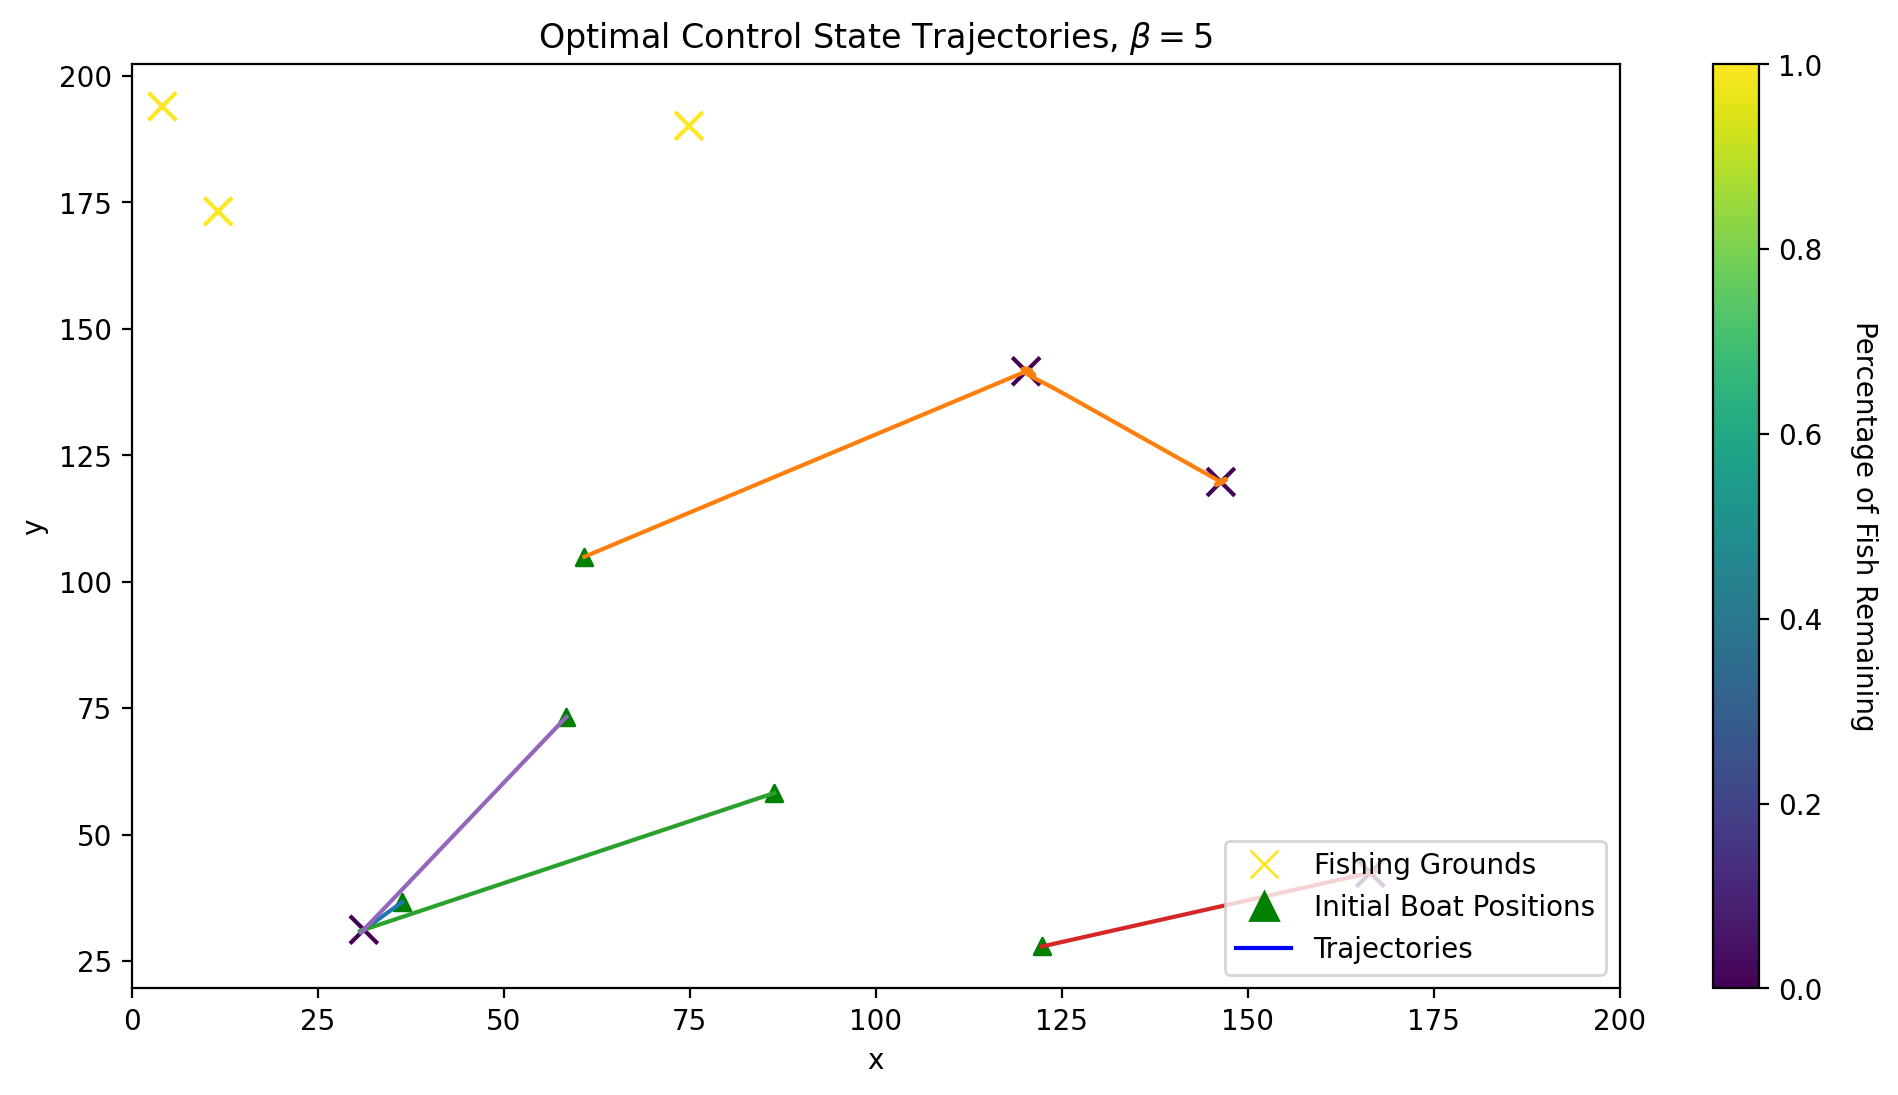

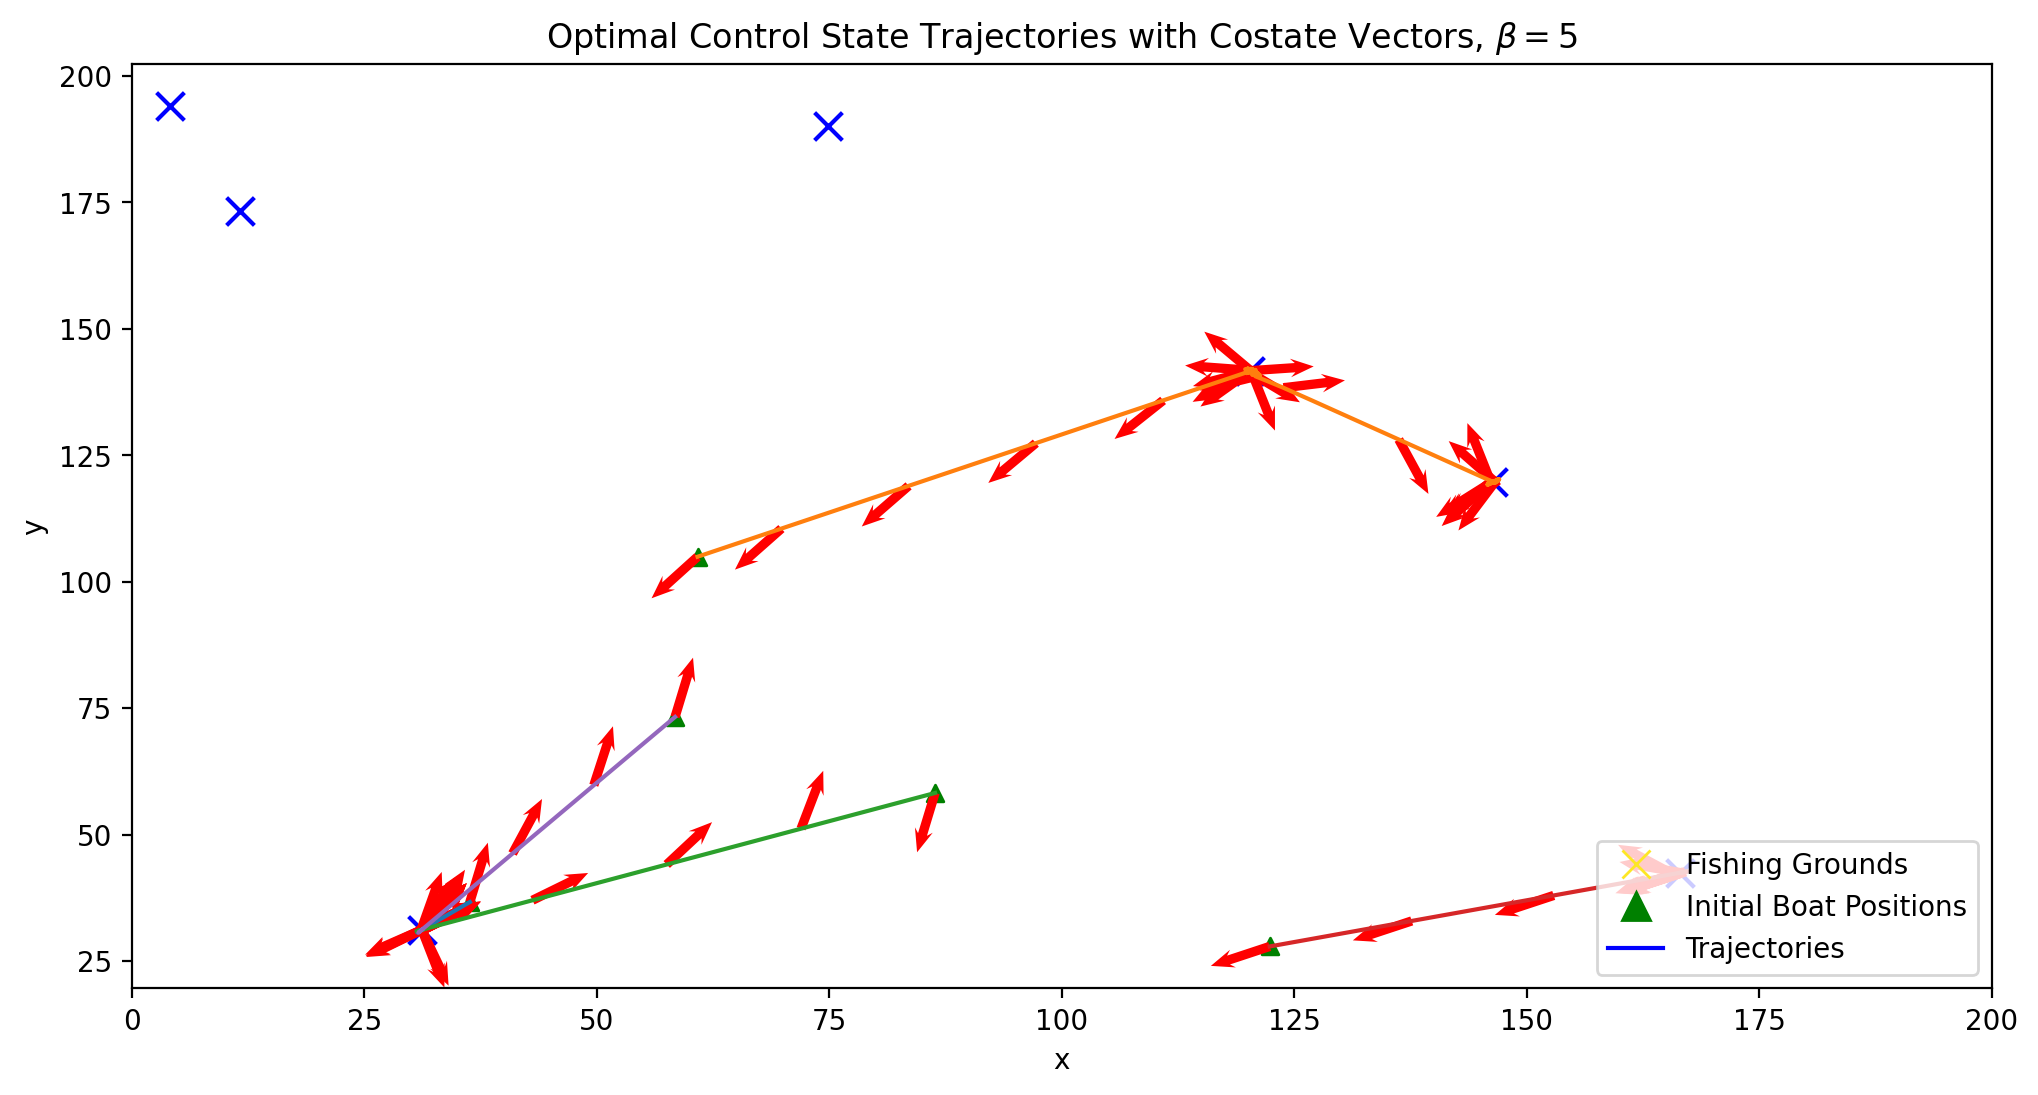

In [61]:
np.random.seed(42)

# Set the grid size
x_max, y_max = 200, 200

# Constants and initial conditions
alpha = 0.005
sigma = 0.05
beta = 5
rate = 0.05
delta = 100
gamma = 0.01
epsilon = .0001
F0 = 1
V = 1

# Bounds for U
u_min = 0
u_max = 10

# Problem dimension set up
n_ships = 5
n_grounds = 7
t_final = 400
num_timesteps = 200

# Initialize scenario
grounds = generate_fishing_grounds(n_grounds, x_max, y_max)
ships = generate_ships(n_ships, x_max, y_max)
N = ships.shape[0]
K = grounds.shape[0]
h = np.array([x_max / 2, 0])

# Initialize U as a tensor of shape (num_timesteps, N, K + 2)
U_tensor = np.ones((num_timesteps, N, K + 2))
U_tensor[:, :, -2] = V
U_tensor[:, :, -1] = V
F = np.ones(K) * F0

# Flatten initial conditions
x = ships
x_size = np.prod(x.shape)
x_shape = x.shape
F_size = np.prod(F.shape)
p_size = x_size
p_shape = x_shape
y0 = np.concatenate((x.flatten(), F))

p_init = np.zeros((n_ships, 2))
pf_init = np.full(F.shape, -delta)
p0 = np.concatenate((p_init.flatten(), pf_init))

U_history = []
P_history = []
pf_history = []
x_history = []

for i in range(1):

    # Define parameters for state function
    state_params = [alpha, sigma, beta, rate, grounds, h, x_size, F_size, x_shape]
    params_costate = [alpha, sigma, beta, epsilon, rate, grounds, h, p_size, F_size, p_shape]

    # Solve state equations
    sol_state = solve_state_equations(state, U_tensor, state_params, t_final, y0, num_timesteps=num_timesteps)

    # print("done")
    # Prepare initial conditions for costate solution

    # Solve costate equations
    sol_costate = solve_costate_equations(costate, sol_state, U_tensor, params_costate, t_final, p0, x_size, F_size, num_timesteps=num_timesteps)
    
    # update initial conditions for p0
    # p0 = sol_costate.y[:, -1]
    # Processing the results
    # Reverse the solutions to match the original time order
    costate_results = sol_costate.y[:, ::-1]

    p_vectors = costate_results[:p_size].reshape(n_ships, 2, -1)
    pf_vectors = costate_results[p_size:]
    P_history.append(p_vectors.copy())
    pf_history.append(pf_vectors.copy())
    x_history.append(sol_state.y[:x_size].reshape((n_ships, 2, -1)).copy())

    x = sol_state.y[:x_size].reshape((n_ships, 2, -1))
    F = sol_state.y[x_size:x_size+F_size]

    # print("Updating U")
    for t in range(num_timesteps):
        ship_positions = x[:, :, t]
        fish_remaining = F[:, t]
        D = d_matrix(ship_positions, grounds)
        G = ship_ground_gaussians(ship_positions, grounds, alpha)

        U = U_tensor[t, :, :]
        speed_control = np.zeros((n_ships))
        for ship in range(n_ships):
            U_ship = U[ship]
            p = p_vectors[ship, :, t]
            # attraction = U_ship[:-2, None] * G[ship, :, None] * D[ship] * fish_remaining[:, None]
            # s = np.sum(attraction, axis=0)
            # orthogonal = np.array([-s[1], s[0]])
            # dot_product = np.dot(p, orthogonal)
            # print("Previous dot product", dot_product)

                        # Regularization strength
            lambda_reg = 0 # Adjust this parameter based on desired smoothness

            # Previous values of U, initialize as needed

            # Bounds for U
            bounds = [(u_min, u_max)] * (K + 1) + [(0, V)]

            
            def minimize_dot_product(U_ship):
                # Calculate the attraction based on current U
                attraction = U_ship[:-2, None] * G[ship, :, None] * D[ship] * fish_remaining[:, None]
                s = np.sum(attraction, axis=0)
                orthogonal = np.array([s[1], -s[0]])
                dot_product = np.dot(p, orthogonal)
                # Regularization term: penalize the square of the difference from the previous U
                regularization = lambda_reg * np.sum((U_tensor[t-1, ship] - U_ship)**2)
                if t == 0:
                    regularization = 0
                return np.abs(dot_product)**2 + regularization
            
            # Find the optimal U for the ship
            res = minimize(minimize_dot_product, U[ship], bounds=[(u_min, u_max)] * (K + 2))
            # print(res)

            U_tensor[t, ship, :] = res.x
            

            attraction = res.x[:-2,None] * G[ship, :, None] * D[ship] * fish_remaining[:, None]
            s = np.sum(attraction, axis=0)
            speed_control[ship] = V*(p @ s / (np.linalg.norm(s) + NORMALIZATOR) + gamma > 0)

            # orthogonal = np.array([-s[1], s[0]])
            # dot_product = np.dot(p, orthogonal)
            # print("Updated dot product", dot_product)
        #U_tensor[t, :, -2] = speed_control
    # print(F[:, -1].shape)
    # sum up over the last time step to get the total fish remaining

    initial_fish = np.sum(F[:, 0])
    total_fish_remaining = np.sum(F[:, -1])
    print("Fish Harvested: ", initial_fish - total_fish_remaining)
    U_history.append(U_tensor.copy())

    F_normalized = F[:, -1] / np.max(F[:, -1])

    fig = plt.figure(figsize=(12, 6))
    fig.patch.set_facecolor('none')

    ax = fig.add_subplot(111)
    ax.patch.set_facecolor('white')

    plt.scatter(grounds[:, 0], grounds[:, 1], c=F_normalized, cmap='viridis', marker='x', s=100, label='Fishing Grounds')

    cbar = plt.colorbar()
    cbar.set_label('Percentage of Fish Remaining', rotation=270, labelpad=20)

    plt.scatter(x[:, 0, 0], x[:, 1, 0], c='green', marker='^')

    for j in range(x.shape[0]):
        plt.plot(x[j, 0, :], x[j, 1, :])

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(fr'Optimal Control State Trajectories, $\beta = {beta}$')

    plt.xlim(0, x_max)
    # plt.ylim(0, y_max)

    fishing_grounds = mlines.Line2D([], [], color='#fde725', marker='x', linestyle='None', markersize=10, label='Fishing Grounds')
    starting_points = mlines.Line2D([], [], color='green', marker='^', linestyle='None', markersize=10, label='Initial Boat Positions')
    trajectories = mlines.Line2D([], [], color='blue', marker='_', linestyle='-', markersize=10, label='Trajectories')

    plt.legend(handles=[fishing_grounds, starting_points, trajectories], loc='lower right')

    # plt.savefig('massive_resolution.png', transparent=True)
    # plt.show()


    fig, ax = plt.subplots(figsize=(12, 6))
    fig.patch.set_facecolor('none')


    # Plot fishing grounds
    plt.scatter(grounds[:, 0], grounds[:, 1], c='blue', marker='x', s=100, label='Fishing Grounds')

    # Initial positions of ships
    plt.scatter(x[:, 0, 0], x[:, 1, 0], c='green', marker='^', label='Initial Boat Positions')

    # Choose a specific number of ships to plot
    # num_ships_to_plot = 2
    # You can select ships randomly:
    # selected_ships = np.random.choice(range(n_ships), num_ships_to_plot, replace=False)
    # Or select specific ships by their indices:
    selected_ships = [i for i in range(n_ships)]  # for example, to choose the first three ships
    # selected_ships = [0, 1]

    # Plot trajectories for selected ships only
    for k in selected_ships:
        plt.plot(x[k, 0, :], x[k, 1, :], label=f'Ship {i+1} Trajectory')

    # Normalize p vectors
    p_vectors = costate_results[:p_size].reshape(n_ships, 2, -1)
    norms = np.linalg.norm(p_vectors[selected_ships], axis=1, keepdims=True)
    normalized_p_vectors = p_vectors[selected_ships] / (norms + NORMALIZATOR)

    # Adjust step for plotting arrows
    step = max(1, num_timesteps // 25)

    # Plot p vectors for selected ships
    for j, idx in enumerate(selected_ships):
        indices = np.arange(0, num_timesteps, step)
        # indices = indices[indices < num_timesteps]  # Ensure indices are within bounds
        ax.quiver(x[idx, 0, indices], x[idx, 1, indices], normalized_p_vectors[j, 0, indices], normalized_p_vectors[j, 1, indices], color='red', scale=30, headwidth=2, headlength=2.5, width=0.005, headaxislength=2)

    # Set labels and titles
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(fr'Optimal Control State Trajectories with Costate Vectors, $\beta = {beta}$')

    # Set plot limits
    plt.xlim(0, x_max)

    # Legend setup
    fishing_grounds = mlines.Line2D([], [], color='#fde725', marker='x', linestyle='None', markersize=10, label='Fishing Grounds')
    starting_points = mlines.Line2D([], [], color='green', marker='^', linestyle='None', markersize=10, label='Initial Boat Positions')
    trajectories = mlines.Line2D([], [], color='blue', marker='_', linestyle='-', markersize=10, label='Trajectories')
    plt.legend(handles=[fishing_grounds, starting_points, trajectories], loc='lower right')

    # plt.show()

    print(f"Iteration {i+1} done")



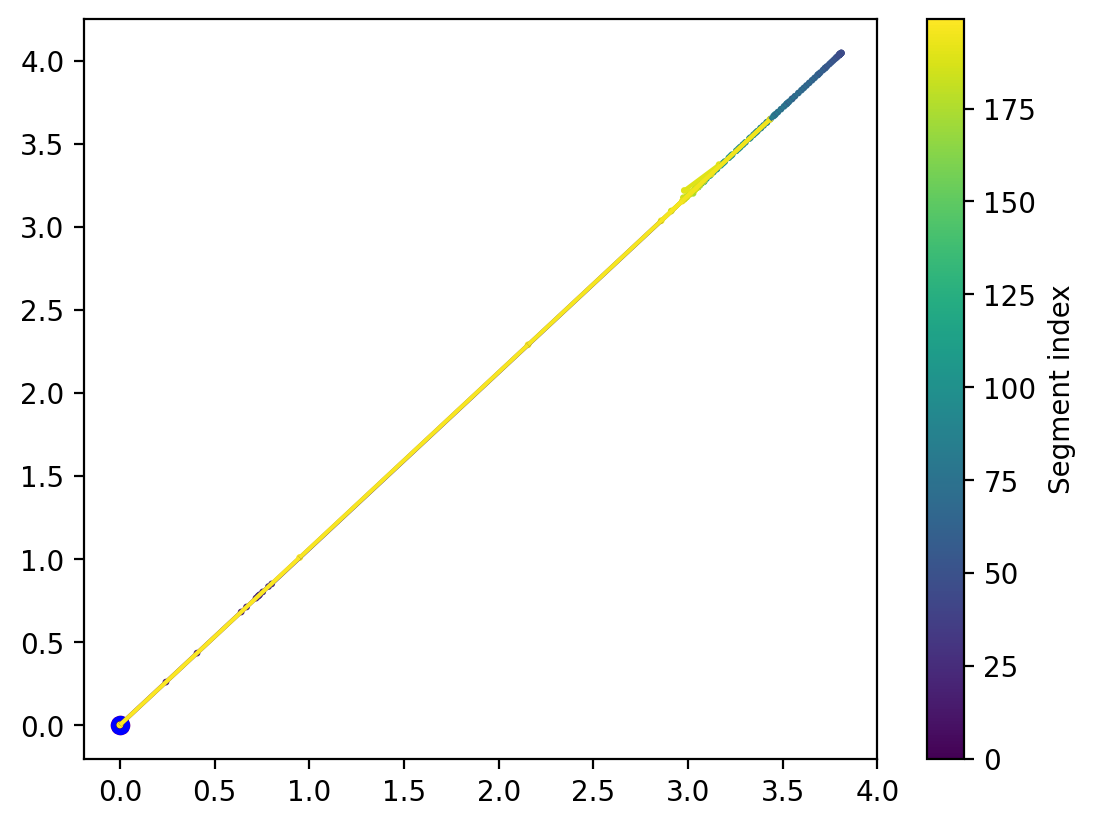

In [56]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm


iteration = 0
ship = 0
length = len(P_history[iteration][0][0])
p_vector = P_history[iteration][0][:,:length]

# Example data (replace this with your actual data)
# Generating random walk data for demonstration
np.random.seed(0)
n = len(p_vector[0])
x = p_vector[0]
y = p_vector[1]

# Create a list of the endpoints for each segment
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Create a continuous norm to map from data points to colors
norm = plt.Normalize(0, n-1)
cmap = plt.get_cmap('viridis')  # Can choose any colormap that you prefer

# Create a LineCollection
lc = LineCollection(segments, cmap=cmap, norm=norm)
# Set the LineCollection to be colored according to the time index
lc.set_array(np.arange(n - 1))

# Plotting
fig, ax = plt.subplots()
ax.add_collection(lc)
#ax.autoscale()
#ax.margins(0.1)
plt.scatter(x[0], y[0], color='red')  # Start point
plt.scatter(x[-1], y[-1], color='blue')  # End point
plt.scatter(x, y, c=np.arange(n), cmap=cmap, s = 2)  # Points on the line
plt.colorbar(lc, label='Segment index')
# plt.xlim(-.2,.2)
# plt.ylim(-.2,.2)

# Ensure that the plot limits are equal and the figure is square-shaped
#ax.set_aspect('equal', adjustable='datalim')
plt.show()There it is there is one but you need like 10 right I did and now it's sense now that's weird OK it's like it's doing like audio thing I don't know it's doing why is it doing this I'm not going to yeah how is it doing this it's typing stuff out as I said hey can you do you say this?


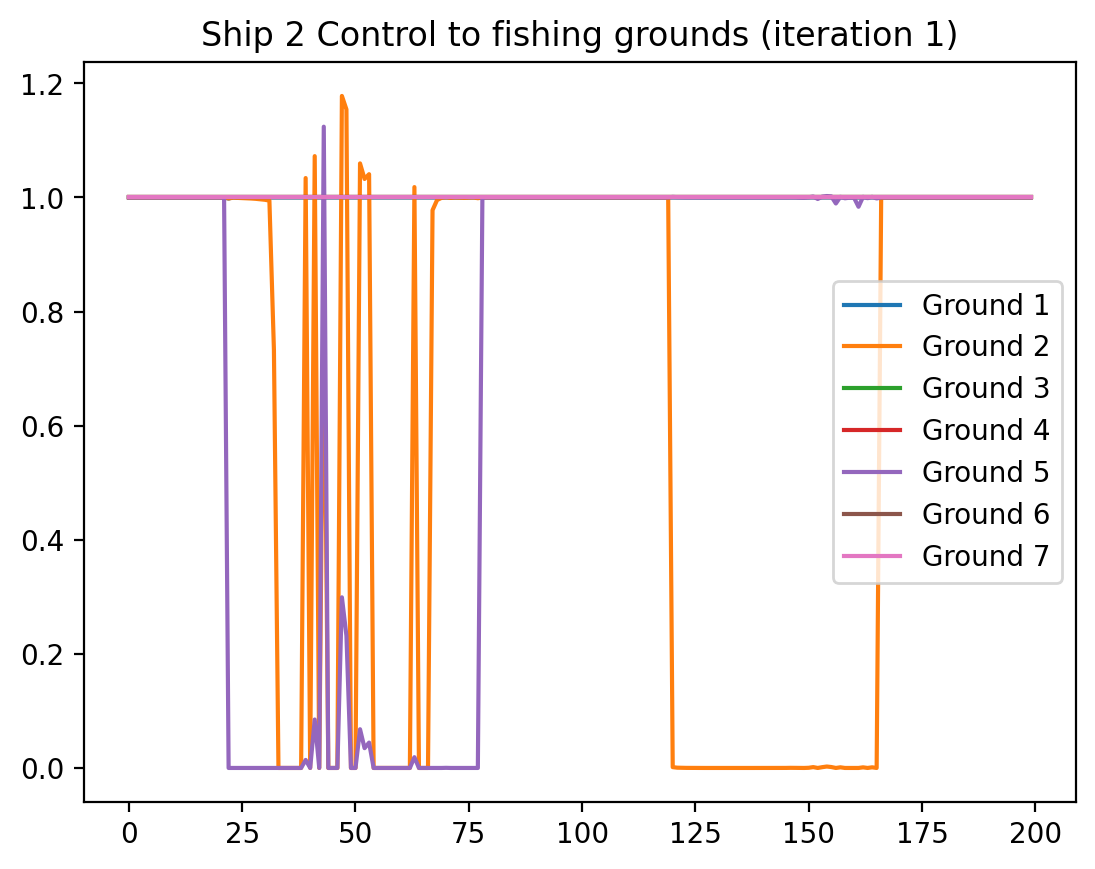

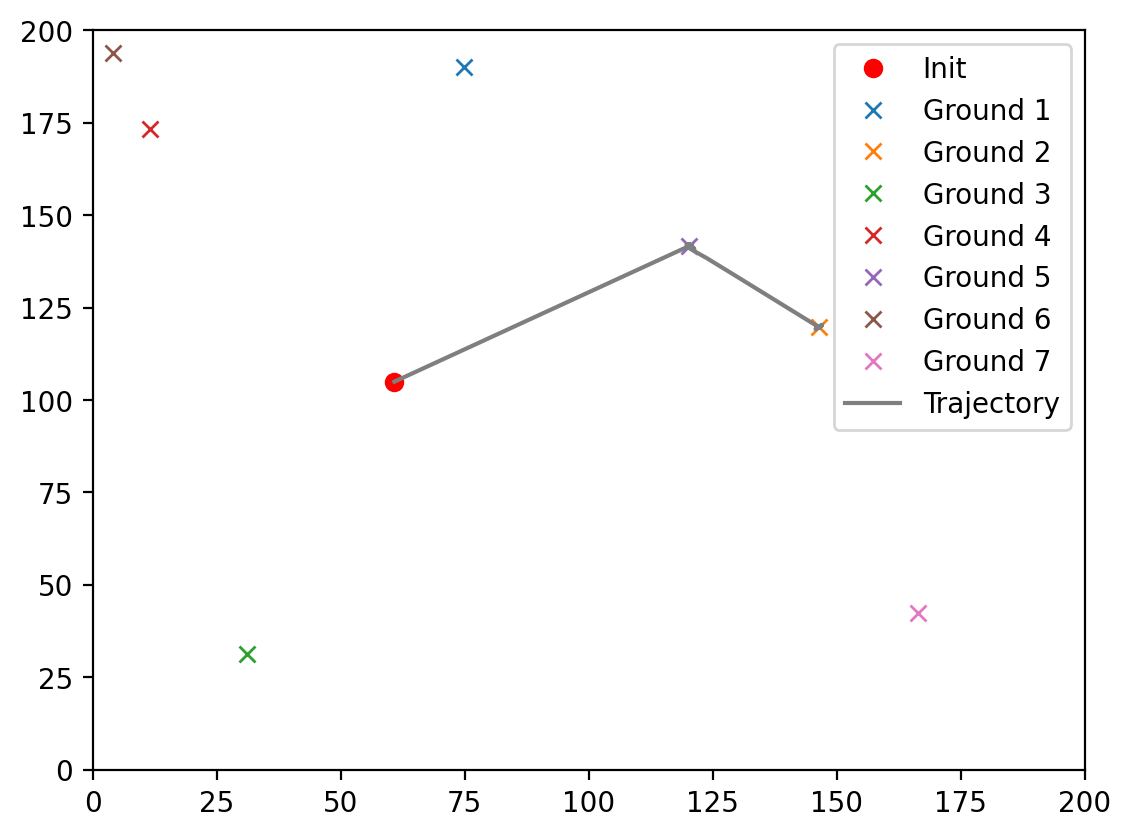

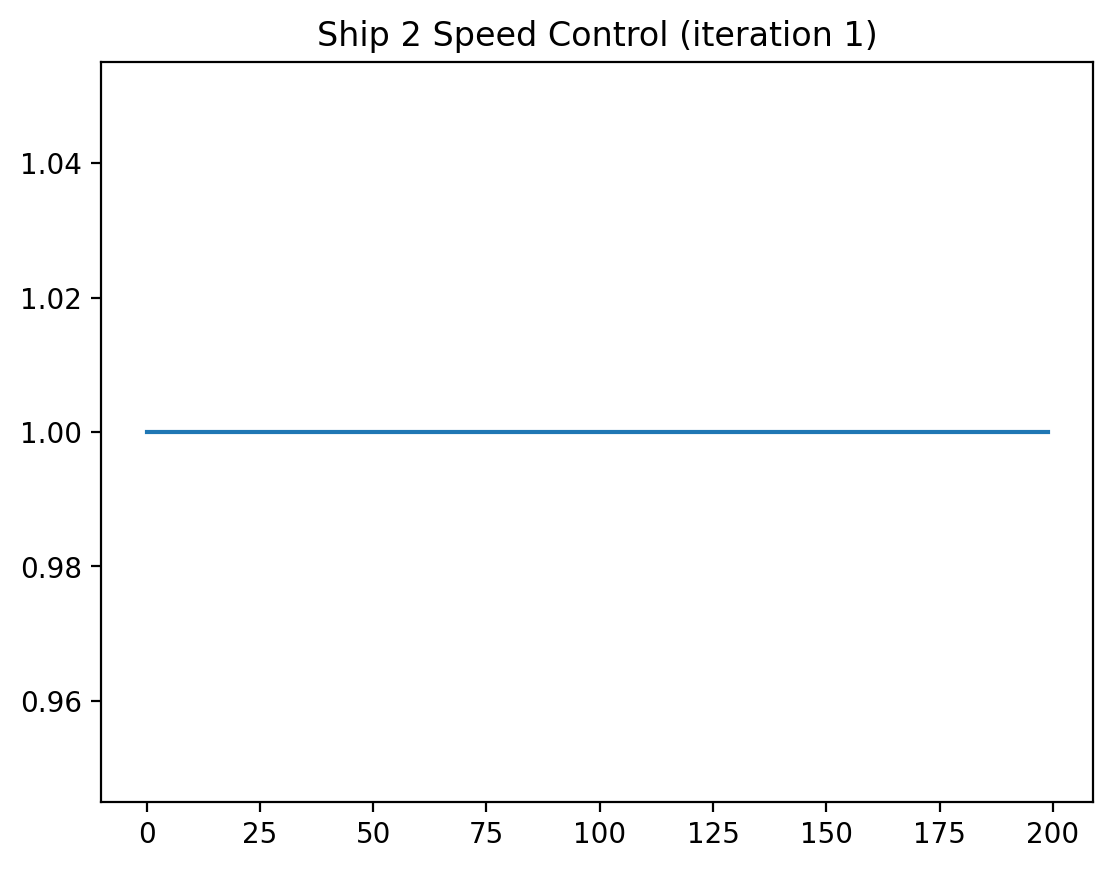

In [62]:
iter = 0
ship = 1
U_control = U_history[iter][:,ship,:-2].T
positions = x_history[iter][ship]

plt.plot(np.arange(len(U_control.T)), U_control.T)
plt.legend([f'Ground {i+1}' for i in range(7)])
plt.title(f'Ship {ship+1} Control to fishing grounds (iteration {iter+1})')
plt.show()

plt.plot(ships[ship, 0], ships[ship, 1], 'ro', label = 'Init')
plt.xlim(0, 200)
plt.ylim(0, 200)
for i in range(7):
    plt.plot(grounds[i, 0], grounds[i, 1], 'x', label = f'Ground {i+1}')
plt.plot(positions[0], positions[1], label = 'Trajectory')
plt.legend()
plt.show()


speed_control = U_history[iter][:,ship,-2]
plt.plot(np.arange(len(speed_control)), speed_control)
plt.title(f'Ship {ship+1} Speed Control (iteration {iter+1})')
plt.show()

In [ ]:
x_max, y_max = 200, 200

# Constants and initial conditions
alpha = 0.0005
sigma = 0.05
beta = 0
rate = 0.01
delta = 100
gamma = 0.00001
epsilon = .001
V = 1

u_min = 0
u_max = 10

n_ships = 5
n_grounds = 7
t_final = 400
num_timesteps = 200

# Initialize scenario
# grounds = generate_fishing_grounds(n_grounds, x_max, y_max)
# ships = generate_ships(n_ships, x_max, y_max)
N = ships.shape[0]
K = grounds.shape[0]
h = np.array([x_max / 2, 0])

# U and F initialization
U = np.ones((N, K + 2))
U[:, -2] = 0
U[:, -1] = 1

F0 = 100
F = np.ones(K) * F0

# Flatten initial conditions
x = ships
x_size = np.prod(x.shape)
x_shape = x.shape
F_size = np.prod(F.shape)
p_size = x_size
p_shape = x_shape
y0 = np.concatenate((x.flatten(), F))

p_init = np.zeros((n_ships, 2))
pf_init = np.full(F.shape, -delta)
p0 = np.concatenate((p_init.flatten(), pf_init))

for i in range(20):

    # Define parameters for state function
    state_params = (alpha, sigma, beta, rate, U, grounds, h, x_size, F_size, x_shape)
    params_costate = [x, F, alpha, sigma, beta, epsilon, rate, U, grounds, h, p_size, F_size, p_shape]

    # Solve state equations
    sol_state = solve_state_equations(state, state_params, t_final, y0, t_eval=num_timesteps)



    print("done")
    # Prepare initial conditions for costate solution


    # Solve costate equations
    sol_costate = solve_costate_equations(costate, sol_state, params_costate, t_final, p0, x_size, F_size, t_eval=num_timesteps)
    
    # update initial conditions for p0
    # p0 = sol_costate.y[:, -1]
    # Processing the results
    # Reverse the solutions to match the original time order
    costate_results = sol_costate.y[:, ::-1]

    p_vectors = costate_results[:p_size].reshape(n_ships, 2, -1)
    pf_vectors = costate_results[p_size:]

    x = sol_state.y[:x_size].reshape((n_ships, 2, -1))
    F = sol_state.y[x_size:x_size+F_size]


    print("Updating U")
    for t in range(num_timesteps):
        ship_positions = x[:, :, t]
        fish_remaining = F[:, t]
        D = d_matrix(ship_positions, grounds)
        G = ship_ground_gaussians(ship_positions, grounds, alpha)
        
        
        for ship in range(n_ships):
            U_ship = U[ship, :-2]
            p = p_vectors[ship, :, t]

            # attraction = U_ship[:-2, None] * G[ship, :, None] * D[ship] * fish_remaining[:, None]
            # s = np.sum(attraction, axis=0)
            # orthogonal = np.array([-s[1], s[0]])
            # print(orthogonal.shape)
            # dot_product = np.dot(p, orthogonal)
            # print("Previous dot product", dot_product)
            def residuals(U_ship):
                attraction = U_ship[:, None] * G[ship, :, None] * D[ship] * fish_remaining[:, None]
                s = np.sum(attraction, axis=0)
                orthogonal = np.array([-s[1], s[0]])
                dot_product = np.dot(p, orthogonal)
                # Return the residual to be minimized (dot_product should be zero)
                return [dot_product]  # Return as a list or array

            # Define bounds for each control in U_ship, assuming U_ship includes all controls for a ship
            lower_bounds = [u_min] * K
            upper_bounds = [u_max] * K

            # Solving the least squares problem with bounds
            res = least_squares(residuals, U[ship, :-2], bounds=(lower_bounds, upper_bounds), method='trf')

            # print(res.x)
            # # print(res)
            U[ship, :-2] = res.x
            # U_ship = U[ship]
            # p = p_vectors[ship, :, t]
            # attraction = U_ship[:-2, None] * G[ship, :, None] * D[ship] * fish_remaining[:, None]
            # s = np.sum(attraction, axis=0)
            # orthogonal = np.array([-s[1], s[0]])
            # dot_product = np.dot(p, orthogonal)
            # print("Updated dot product", dot_product)

            # attraction = U[ship][:-2, None] * G[ship, :, None] * D[ship] * fish_remaining[:, None]
            # s = np.sum(attraction, axis=0)

            # print((np.dot(p, (s / (np.linalg.norm(s) + NORMALIZATOR))) + gamma) > 0)

            # if (np.dot(p, (s / (np.linalg.norm(s) + NORMALIZATOR))) + gamma) > 0:
            #     U[ship, -1] = V
            # else:
            #     U[ship, -1] = 0
    print(F[:, -1].shape)
    # sum up over the last time step to get the total fish remaining
    initial_fish = np.sum(F[:, 0])
    total_fish_remaining = np.sum(F[:, -1])
    print(initial_fish)
    print(total_fish_remaining)

    # # Calculate the cost functional

    print(f"Iteration {i+1} done")



TypeError: solve_state_equations() got an unexpected keyword argument 't_eval'

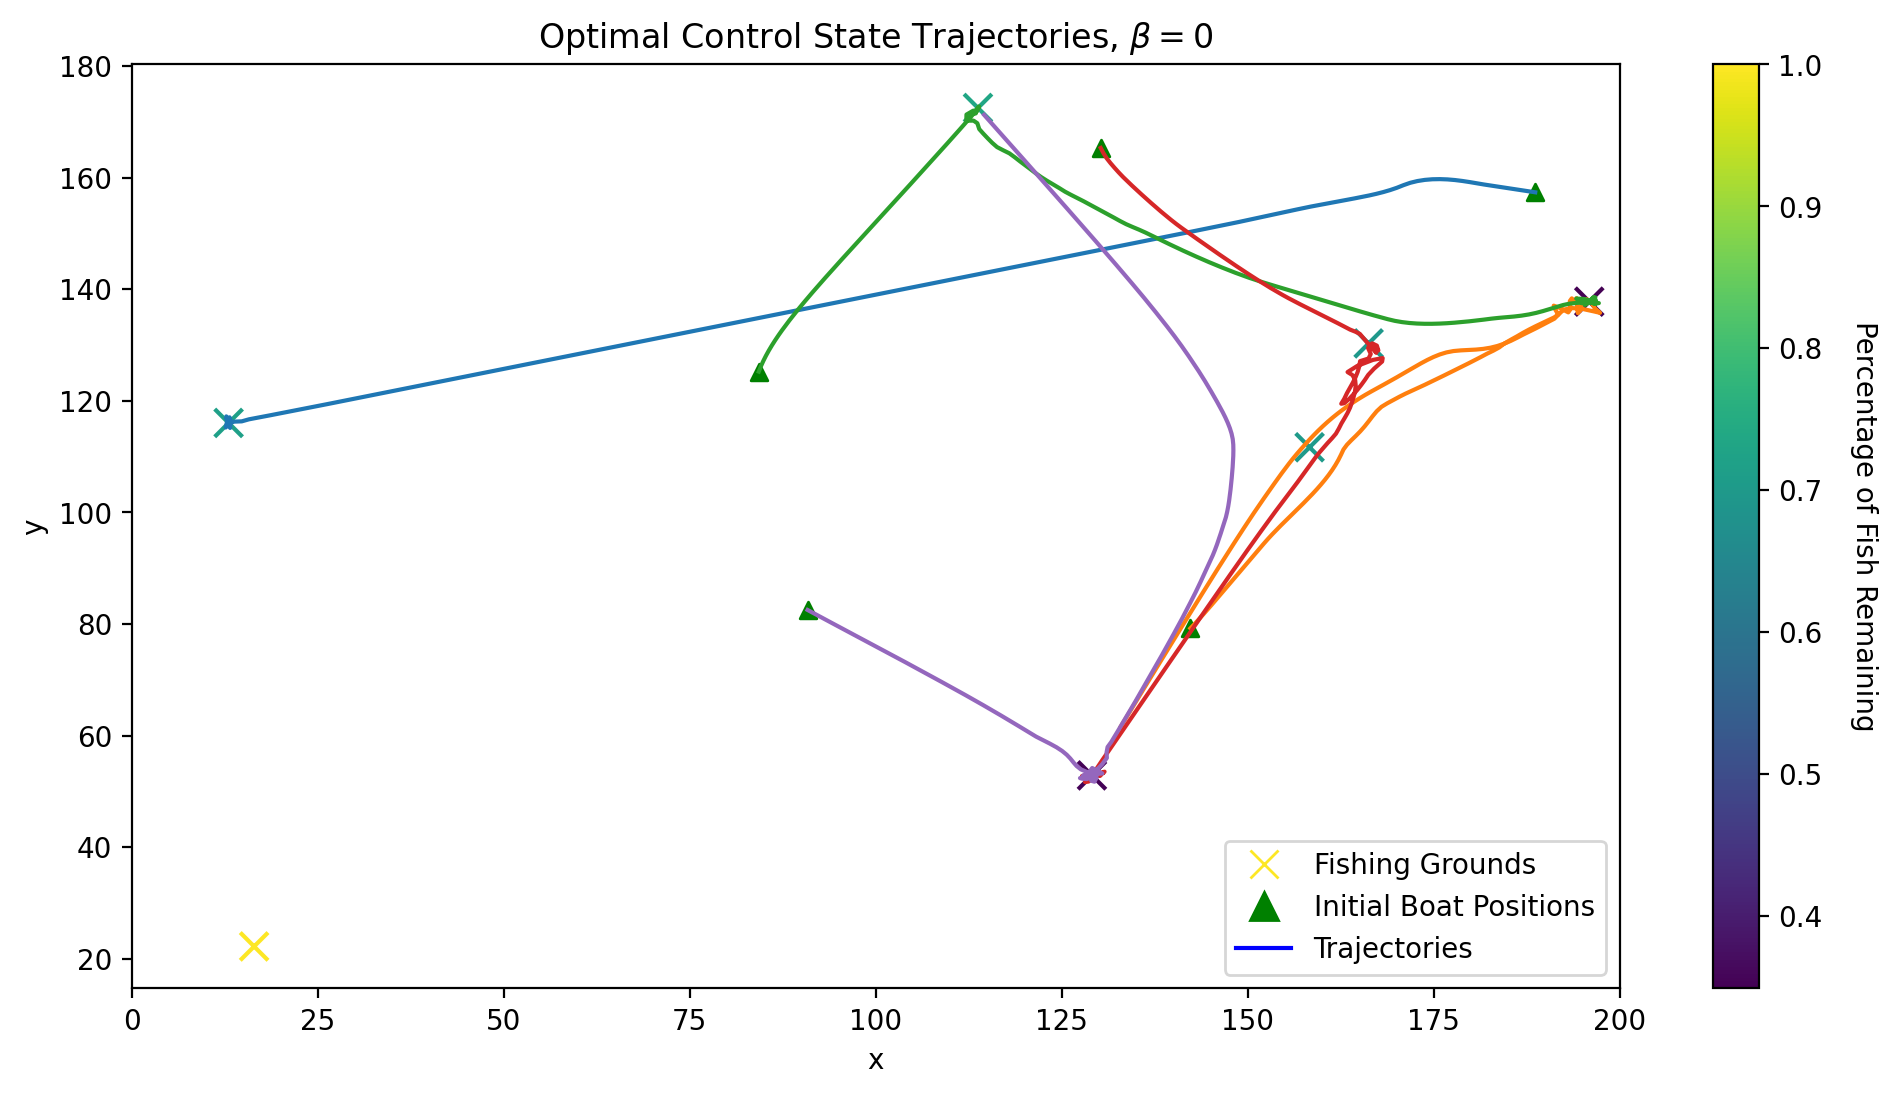

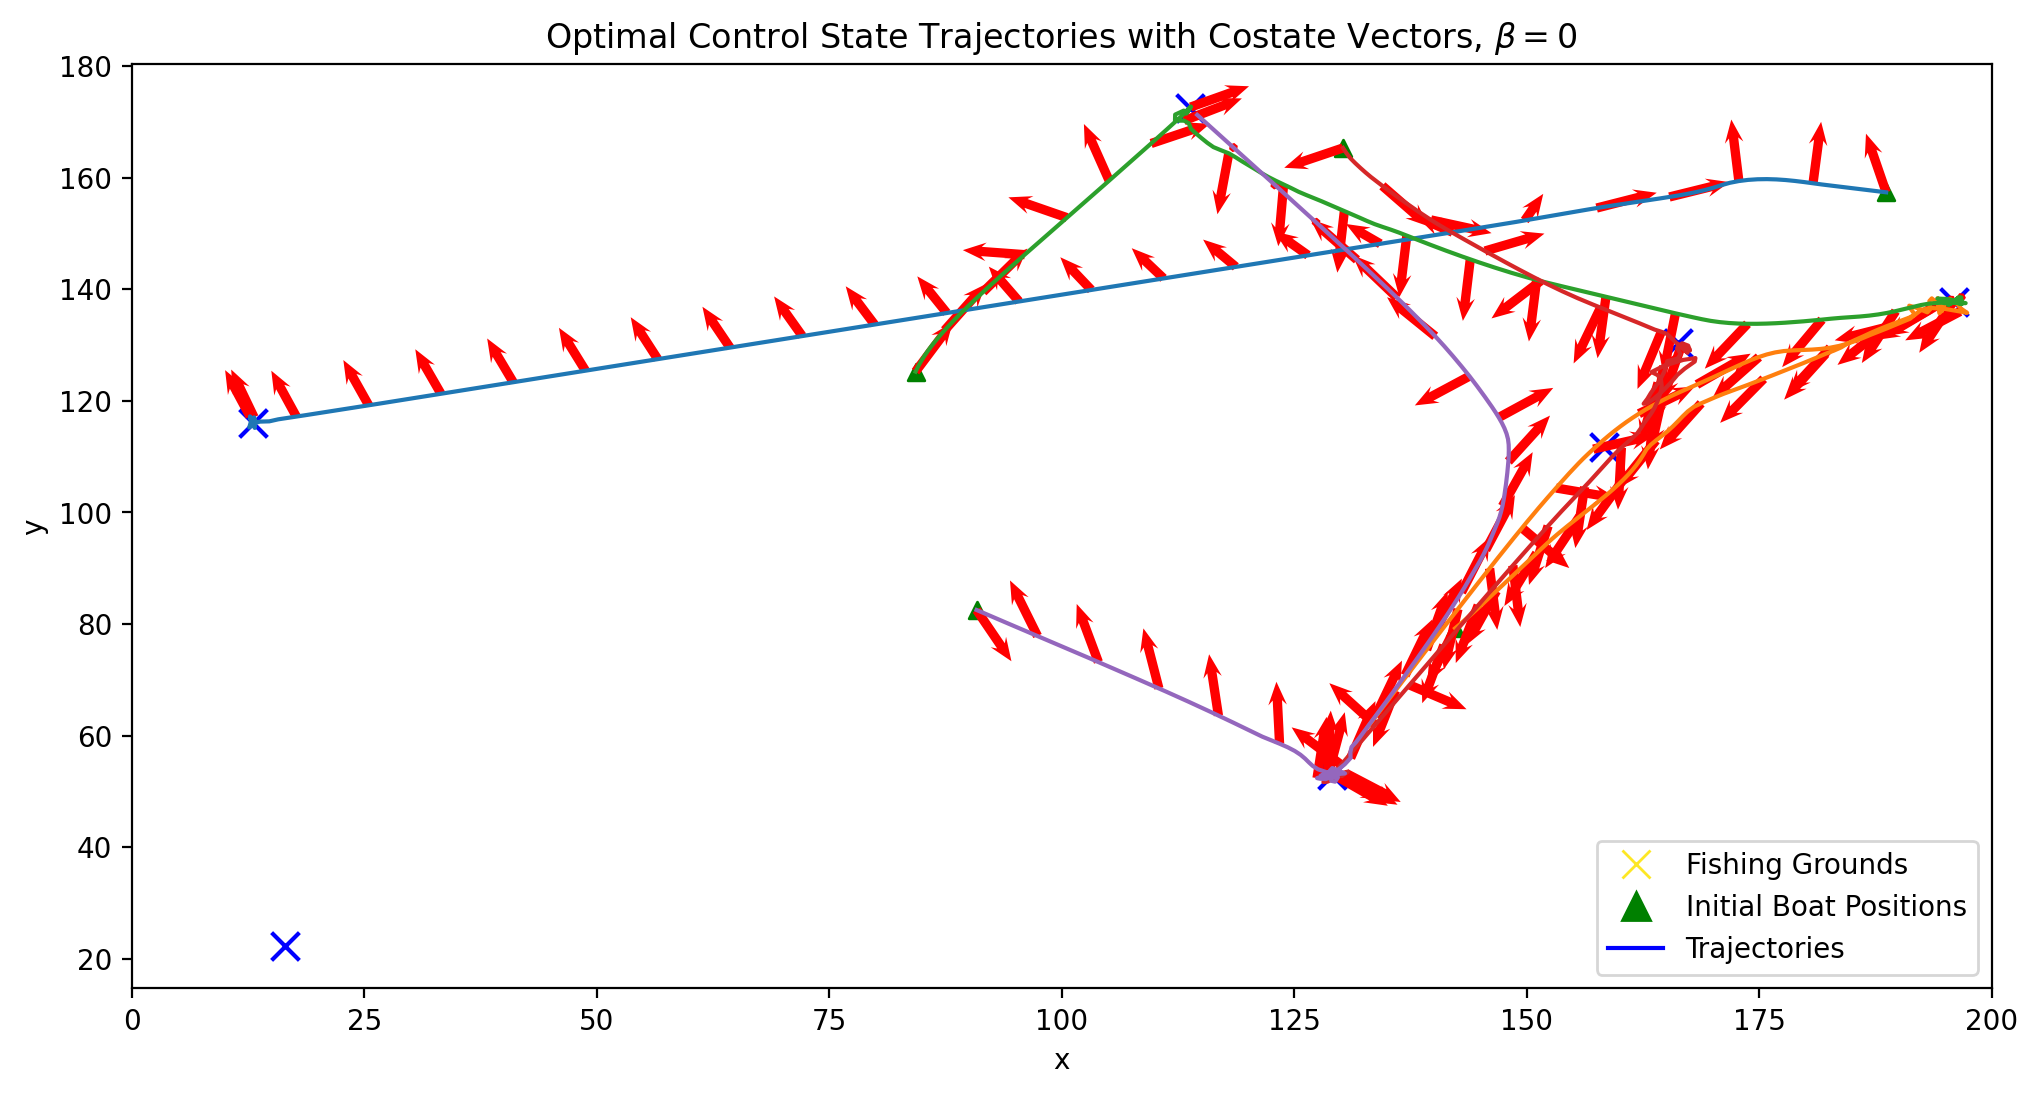

In [ ]:

F_normalized = F[:, -1] / np.max(F[:, -1])

fig = plt.figure(figsize=(12, 6))
fig.patch.set_facecolor('none')

ax = fig.add_subplot(111)
ax.patch.set_facecolor('white')

plt.scatter(grounds[:, 0], grounds[:, 1], c=F_normalized, cmap='viridis', marker='x', s=100, label='Fishing Grounds')

cbar = plt.colorbar()
cbar.set_label('Percentage of Fish Remaining', rotation=270, labelpad=20)

plt.scatter(x[:, 0, 0], x[:, 1, 0], c='green', marker='^')

for i in range(x.shape[0]):
    plt.plot(x[i, 0, :], x[i, 1, :])

plt.xlabel('x')
plt.ylabel('y')
plt.title(fr'Optimal Control State Trajectories, $\beta = {beta}$')

plt.xlim(0, x_max)
# plt.ylim(0, y_max)

fishing_grounds = mlines.Line2D([], [], color='#fde725', marker='x', linestyle='None', markersize=10, label='Fishing Grounds')
starting_points = mlines.Line2D([], [], color='green', marker='^', linestyle='None', markersize=10, label='Initial Boat Positions')
trajectories = mlines.Line2D([], [], color='blue', marker='_', linestyle='-', markersize=10, label='Trajectories')

plt.legend(handles=[fishing_grounds, starting_points, trajectories], loc='lower right')

# plt.savefig('massive_resolution.png', transparent=True)
plt.show()


fig, ax = plt.subplots(figsize=(12, 6))
fig.patch.set_facecolor('none')


# Plot fishing grounds
plt.scatter(grounds[:, 0], grounds[:, 1], c='blue', marker='x', s=100, label='Fishing Grounds')

# Initial positions of ships
plt.scatter(x[:, 0, 0], x[:, 1, 0], c='green', marker='^', label='Initial Boat Positions')

# Choose a specific number of ships to plot
# num_ships_to_plot = 2
# You can select ships randomly:
# selected_ships = np.random.choice(range(n_ships), num_ships_to_plot, replace=False)
# Or select specific ships by their indices:
selected_ships = [i for i in range(n_ships)]  # for example, to choose the first three ships
# selected_ships = [0, 1]

# Plot trajectories for selected ships only
for i in selected_ships:
    plt.plot(x[i, 0, :], x[i, 1, :], label=f'Ship {i+1} Trajectory')

# Normalize p vectors
p_vectors = costate_results[:p_size].reshape(n_ships, 2, -1)
norms = np.linalg.norm(p_vectors[selected_ships], axis=1, keepdims=True)
normalized_p_vectors = p_vectors[selected_ships] / (norms + NORMALIZATOR)

# Adjust step for plotting arrows
step = max(1, num_timesteps // 25)

# Plot p vectors for selected ships
for i, idx in enumerate(selected_ships):
    indices = np.arange(0, num_timesteps, step)
    # indices = indices[indices < num_timesteps]  # Ensure indices are within bounds
    ax.quiver(x[idx, 0, indices], x[idx, 1, indices], normalized_p_vectors[i, 0, indices], normalized_p_vectors[i, 1, indices], color='red', scale=30, headwidth=2, headlength=2.5, width=0.005, headaxislength=2)

# Set labels and titles
plt.xlabel('x')
plt.ylabel('y')
plt.title(fr'Optimal Control State Trajectories with Costate Vectors, $\beta = {beta}$')

# Set plot limits
plt.xlim(0, x_max)

# Legend setup
fishing_grounds = mlines.Line2D([], [], color='#fde725', marker='x', linestyle='None', markersize=10, label='Fishing Grounds')
starting_points = mlines.Line2D([], [], color='green', marker='^', linestyle='None', markersize=10, label='Initial Boat Positions')
trajectories = mlines.Line2D([], [], color='blue', marker='_', linestyle='-', markersize=10, label='Trajectories')
plt.legend(handles=[fishing_grounds, starting_points, trajectories], loc='lower right')

plt.show()


In [ ]:

# U and F initialization
U = np.ones((N, K + 2))
U[:, -2] = 0
U[:, -1] = 1

F0 = 100
F = np.ones(K) * F0

# Flatten initial conditions
x = ships
x_size = np.prod(x.shape)
x_shape = x.shape
F_size = np.prod(F.shape)
p_size = x_size
p_shape = x_shape
y0 = np.concatenate((x.flatten(), F))

p_init = np.zeros((n_ships, 2))
pf_init = np.full(F.shape, -delta)
p0 = np.concatenate((p_init.flatten(), pf_init))

for i in range(1):

    # Define parameters for state function
    state_params = (alpha, sigma, beta, rate, U, grounds, h, x_size, F_size, x_shape)
    params_costate = [x, F, alpha, sigma, beta, rate, U, grounds, h, p_size, F_size, p_shape]

    # Solve state equations
    sol_state = solve_state_equations(state, state_params, t_final, y0, t_eval=num_timesteps)



    print("done")
    # Prepare initial conditions for costate solution


    # Solve costate equations
    sol_costate = solve_costate_equations(costate, sol_state, params_costate, t_final, p0, x_size, F_size, t_eval=num_timesteps)
    
    # update initial conditions for p0
    # p0 = sol_costate.y[:, -1]
    # Processing the results
    # Reverse the solutions to match the original time order
    costate_results = sol_costate.y[:, ::-1]

    p_vectors = costate_results[:p_size].reshape(n_ships, 2, -1)
    pf_vectors = costate_results[p_size:]

    x = sol_state.y[:x_size].reshape((n_ships, 2, -1))
    F = sol_state.y[x_size:x_size+F_size]

done


In [ ]:
print(F[:, -1].shape)
# sum up over the last time step to get the total fish remaining
initial_fish = np.sum(F[:, 0])
total_fish_remaining = np.sum(F[:, -1])
print(initial_fish)
print(total_fish_remaining)

(7,)
700.0
678.2629715389925


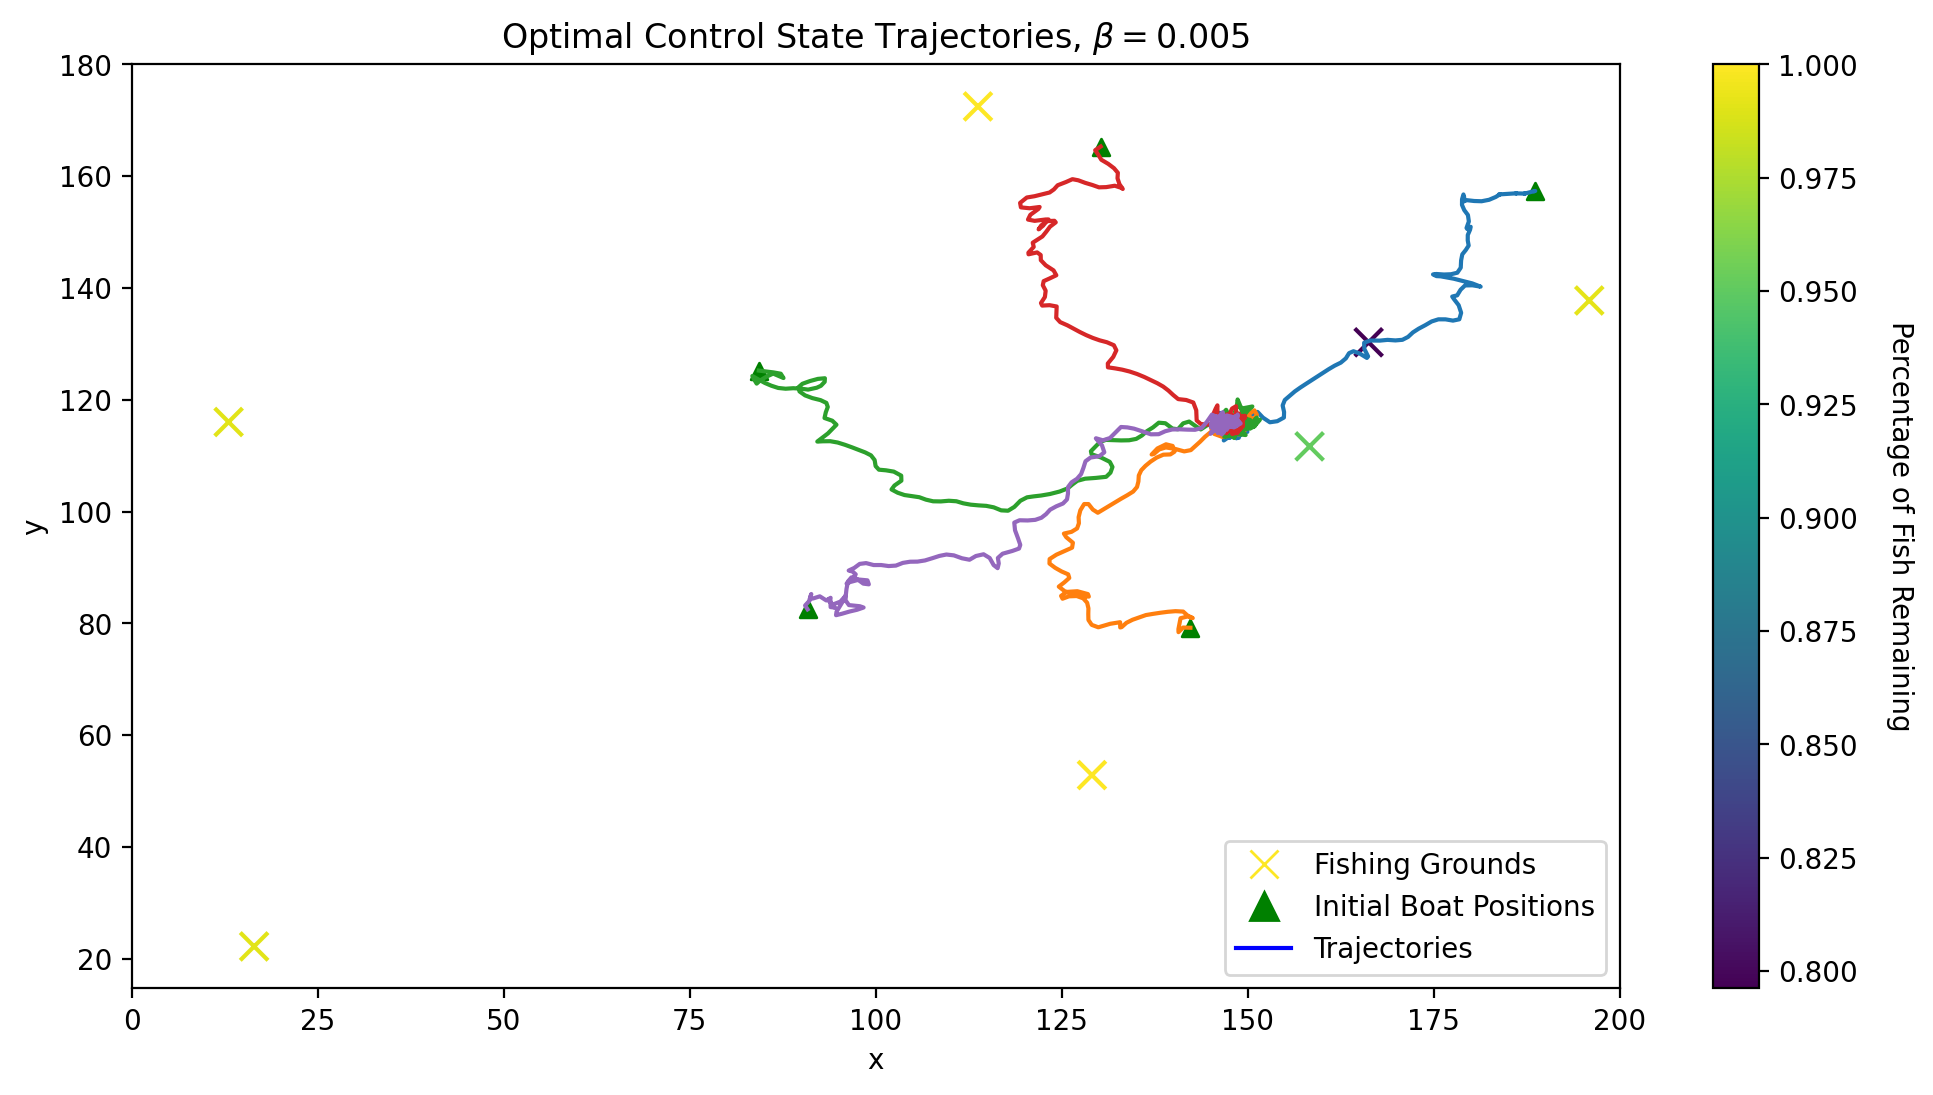

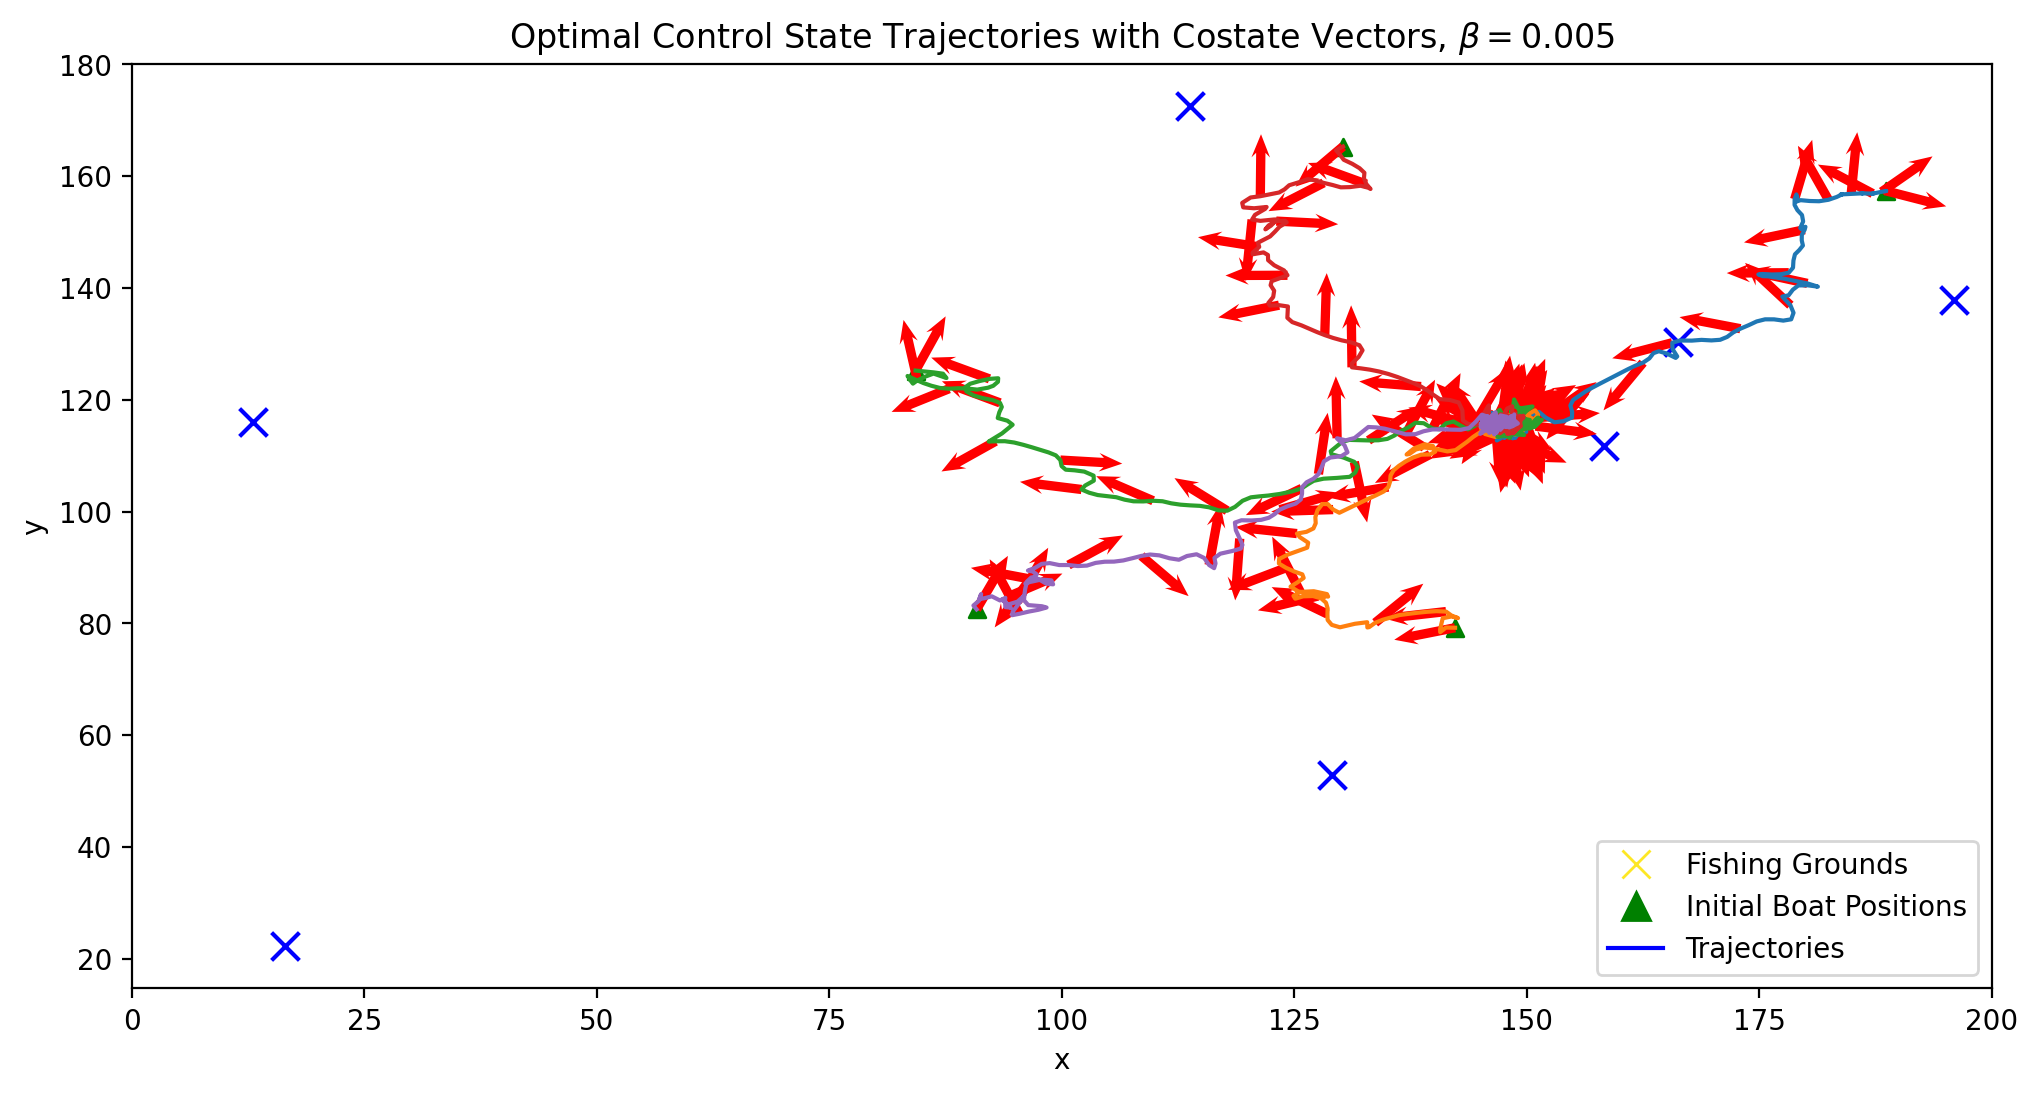

In [ ]:

F_normalized = F[:, -1] / np.max(F[:, -1])

fig = plt.figure(figsize=(12, 6))
fig.patch.set_facecolor('none')

ax = fig.add_subplot(111)
ax.patch.set_facecolor('white')

plt.scatter(grounds[:, 0], grounds[:, 1], c=F_normalized, cmap='viridis', marker='x', s=100, label='Fishing Grounds')

cbar = plt.colorbar()
cbar.set_label('Percentage of Fish Remaining', rotation=270, labelpad=20)

plt.scatter(x[:, 0, 0], x[:, 1, 0], c='green', marker='^')

for i in range(x.shape[0]):
    plt.plot(x[i, 0, :], x[i, 1, :])

plt.xlabel('x')
plt.ylabel('y')
plt.title(fr'Optimal Control State Trajectories, $\beta = {beta}$')

plt.xlim(0, x_max)
# plt.ylim(0, y_max)

fishing_grounds = mlines.Line2D([], [], color='#fde725', marker='x', linestyle='None', markersize=10, label='Fishing Grounds')
starting_points = mlines.Line2D([], [], color='green', marker='^', linestyle='None', markersize=10, label='Initial Boat Positions')
trajectories = mlines.Line2D([], [], color='blue', marker='_', linestyle='-', markersize=10, label='Trajectories')

plt.legend(handles=[fishing_grounds, starting_points, trajectories], loc='lower right')

# plt.savefig('massive_resolution.png', transparent=True)
plt.show()


fig, ax = plt.subplots(figsize=(12, 6))
fig.patch.set_facecolor('none')


# Plot fishing grounds
plt.scatter(grounds[:, 0], grounds[:, 1], c='blue', marker='x', s=100, label='Fishing Grounds')

# Initial positions of ships
plt.scatter(x[:, 0, 0], x[:, 1, 0], c='green', marker='^', label='Initial Boat Positions')

# Choose a specific number of ships to plot
# num_ships_to_plot = 2
# You can select ships randomly:
# selected_ships = np.random.choice(range(n_ships), num_ships_to_plot, replace=False)
# Or select specific ships by their indices:
selected_ships = [i for i in range(n_ships)]  # for example, to choose the first three ships
# selected_ships = [0, 1]

# Plot trajectories for selected ships only
for i in selected_ships:
    plt.plot(x[i, 0, :], x[i, 1, :], label=f'Ship {i+1} Trajectory')

# Normalize p vectors
p_vectors = costate_results[:p_size].reshape(n_ships, 2, -1)
norms = np.linalg.norm(p_vectors[selected_ships], axis=1, keepdims=True)
normalized_p_vectors = p_vectors[selected_ships] / (norms + NORMALIZATOR)

# Adjust step for plotting arrows
step = max(1, num_timesteps // 25)

# Plot p vectors for selected ships
for i, idx in enumerate(selected_ships):
    indices = np.arange(0, num_timesteps, step)
    # indices = indices[indices < num_timesteps]  # Ensure indices are within bounds
    ax.quiver(x[idx, 0, indices], x[idx, 1, indices], normalized_p_vectors[i, 0, indices], normalized_p_vectors[i, 1, indices], color='red', scale=30, headwidth=2, headlength=2.5, width=0.005, headaxislength=2)

# Set labels and titles
plt.xlabel('x')
plt.ylabel('y')
plt.title(fr'Optimal Control State Trajectories with Costate Vectors, $\beta = {beta}$')

# Set plot limits
plt.xlim(0, x_max)

# Legend setup
fishing_grounds = mlines.Line2D([], [], color='#fde725', marker='x', linestyle='None', markersize=10, label='Fishing Grounds')
starting_points = mlines.Line2D([], [], color='green', marker='^', linestyle='None', markersize=10, label='Initial Boat Positions')
trajectories = mlines.Line2D([], [], color='blue', marker='_', linestyle='-', markersize=10, label='Trajectories')
plt.legend(handles=[fishing_grounds, starting_points, trajectories], loc='lower right')

plt.show()


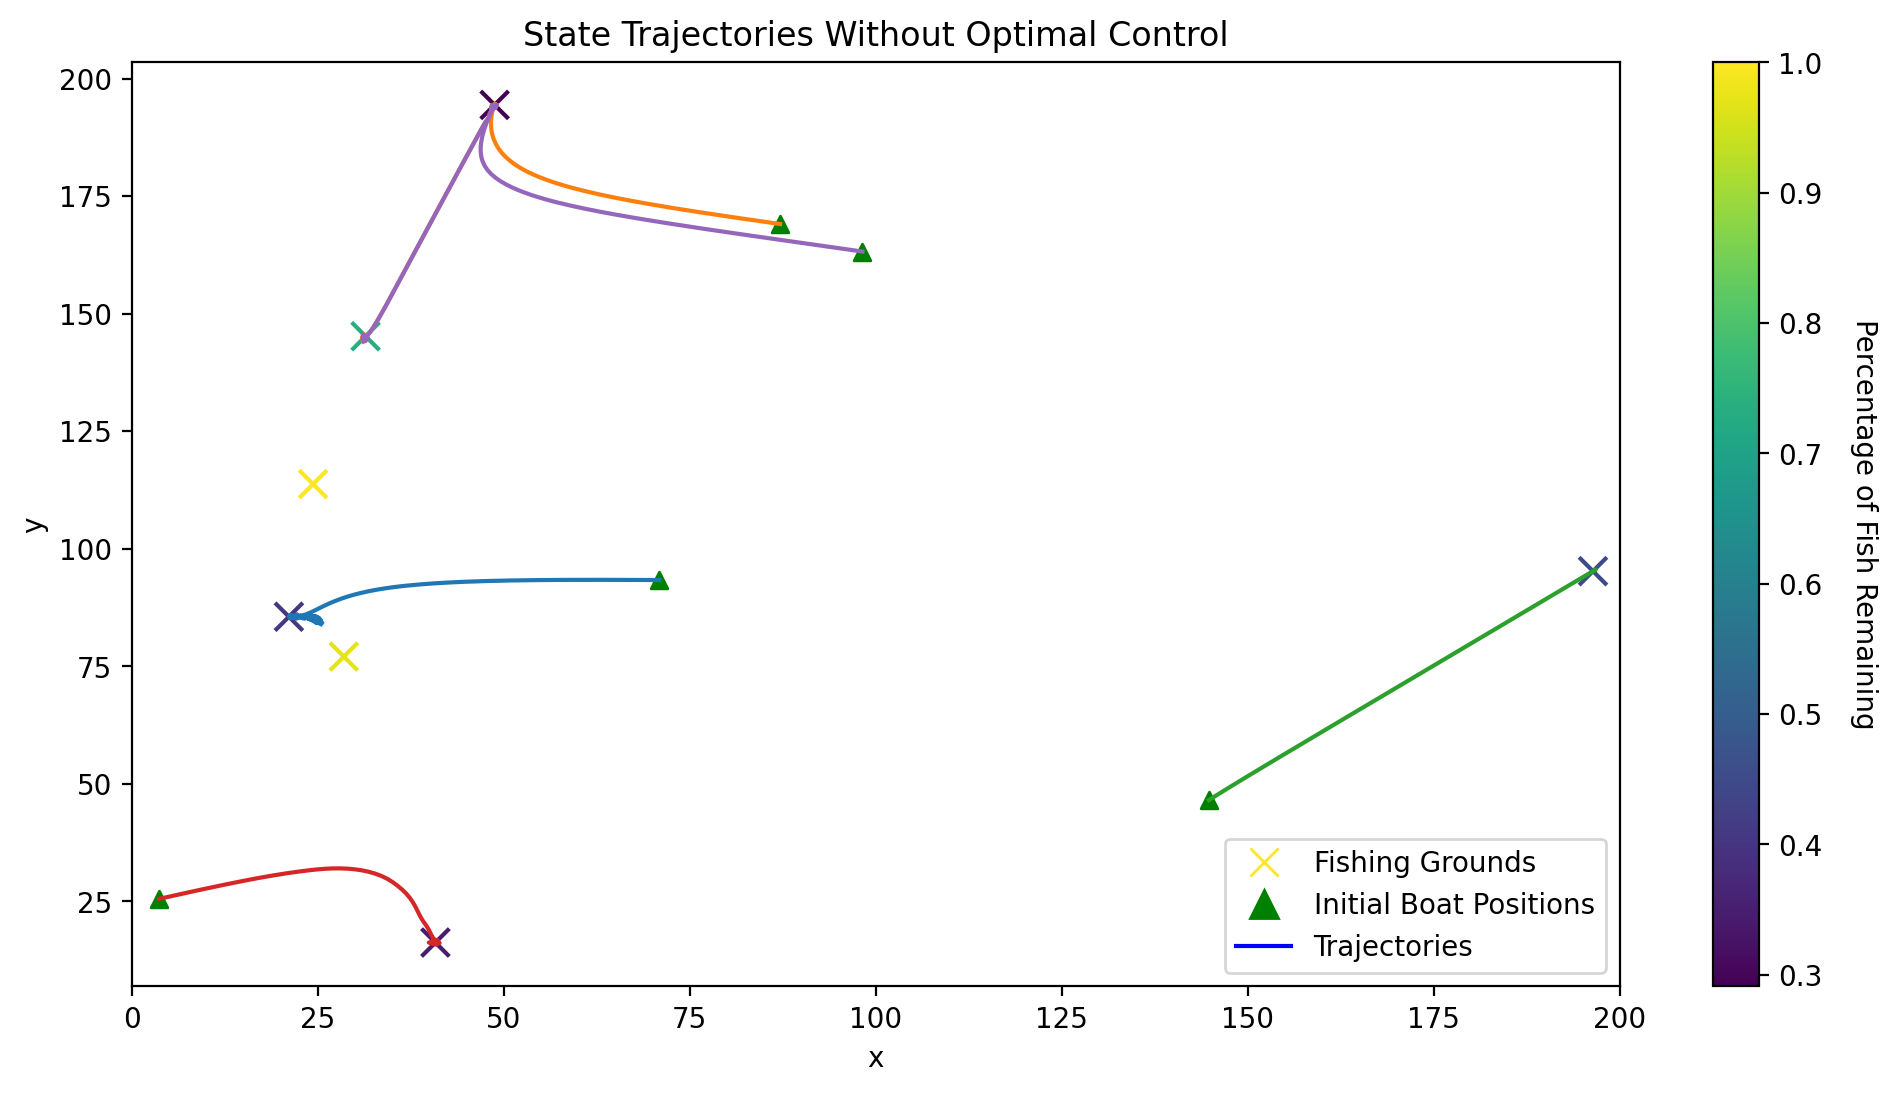

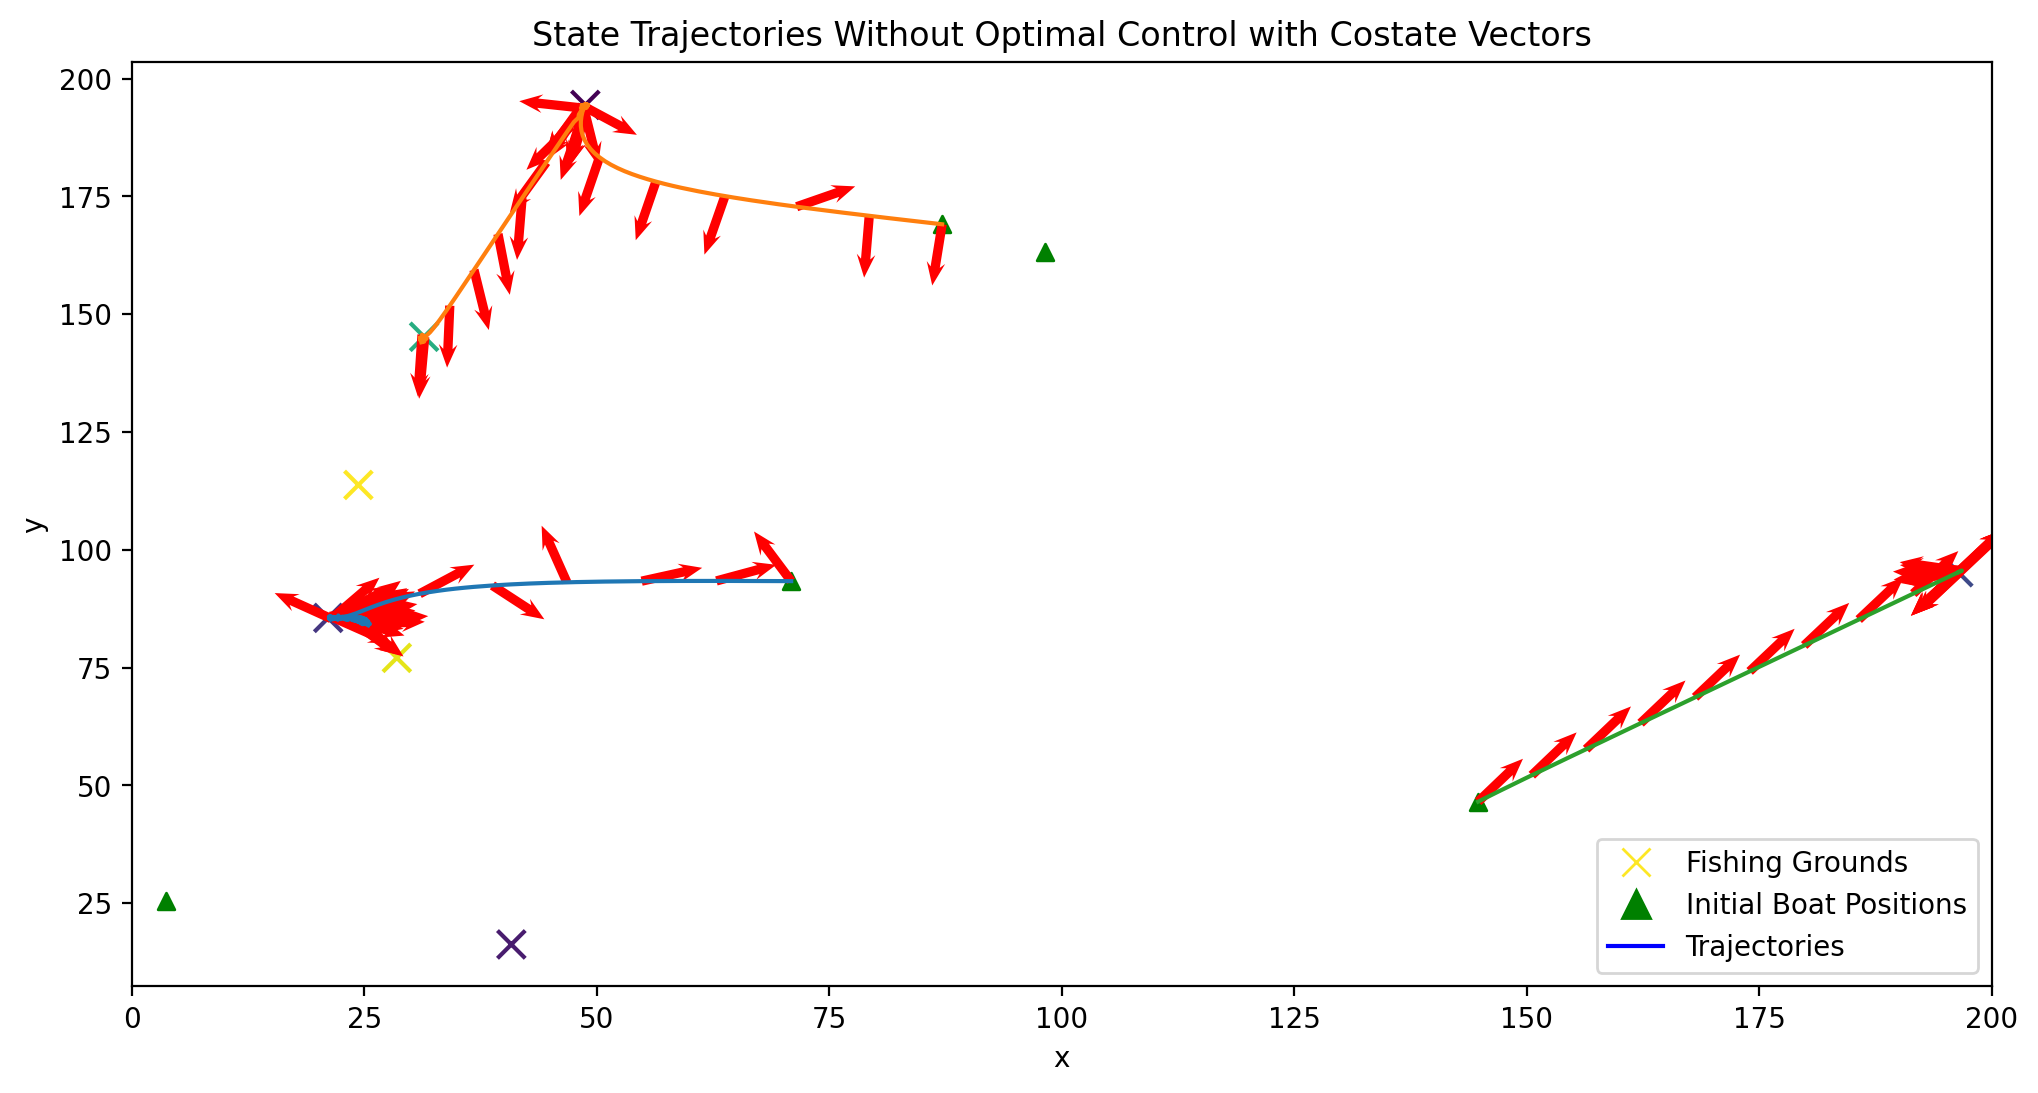

In [ ]:

F_normalized = F[:, -1] / np.max(F[:, -1])

fig = plt.figure(figsize=(12, 6))
fig.patch.set_facecolor('none')

ax = fig.add_subplot(111)
ax.patch.set_facecolor('white')

plt.scatter(grounds[:, 0], grounds[:, 1], c=F_normalized, cmap='viridis', marker='x', s=100, label='Fishing Grounds')

cbar = plt.colorbar()
cbar.set_label('Percentage of Fish Remaining', rotation=270, labelpad=20)

plt.scatter(x[:, 0, 0], x[:, 1, 0], c='green', marker='^')

for i in range(x.shape[0]):
    plt.plot(x[i, 0, :], x[i, 1, :])

plt.xlabel('x')
plt.ylabel('y')
plt.title('State Trajectories Without Optimal Control')

plt.xlim(0, x_max)
# plt.ylim(0, y_max)

fishing_grounds = mlines.Line2D([], [], color='#fde725', marker='x', linestyle='None', markersize=10, label='Fishing Grounds')
starting_points = mlines.Line2D([], [], color='green', marker='^', linestyle='None', markersize=10, label='Initial Boat Positions')
trajectories = mlines.Line2D([], [], color='blue', marker='_', linestyle='-', markersize=10, label='Trajectories')

plt.legend(handles=[fishing_grounds, starting_points, trajectories], loc='lower right')

# plt.savefig('massive_resolution.png', transparent=True)
plt.show()


fig, ax = plt.subplots(figsize=(12, 6))
ax.set_facecolor('white')

# Plot fishing grounds
plt.scatter(grounds[:, 0], grounds[:, 1], c=F_normalized, cmap='viridis', marker='x', s=100, label='Fishing Grounds')

# Initial positions of ships
plt.scatter(x[:, 0, 0], x[:, 1, 0], c='green', marker='^', label='Initial Boat Positions')

# Choose a specific number of ships to plot
num_ships_to_plot = 2
# You can select ships randomly:
# selected_ships = np.random.choice(range(n_ships), num_ships_to_plot, replace=False)
# Or select specific ships by their indices:
selected_ships = [0, 1, 2]  # for example, to choose the first three ships

# Plot trajectories for selected ships only
for i in selected_ships:
    plt.plot(x[i, 0, :], x[i, 1, :], label=f'Ship {i+1} Trajectory')

# Normalize p vectors
p_vectors = costate_results[:p_size].reshape(n_ships, 2, -1)
norms = np.linalg.norm(p_vectors[selected_ships], axis=1, keepdims=True)
normalized_p_vectors = p_vectors[selected_ships] / (norms + NORMALIZATOR)

# Adjust step for plotting arrows
step = max(1, num_timesteps // 25)

# Plot p vectors for selected ships
for i, idx in enumerate(selected_ships):
    indices = np.arange(0, num_timesteps, step)
    # indices = indices[indices < num_timesteps]  # Ensure indices are within bounds
    ax.quiver(x[idx, 0, indices], x[idx, 1, indices], normalized_p_vectors[i, 0, indices], normalized_p_vectors[i, 1, indices], color='red', scale=30, headwidth=2, headlength=2.5, width=0.005, headaxislength=2)

# Set labels and titles
plt.xlabel('x')
plt.ylabel('y')
plt.title('State Trajectories Without Optimal Control with Costate Vectors')

# Set plot limits
plt.xlim(0, x_max)

# Legend setup
fishing_grounds = mlines.Line2D([], [], color='#fde725', marker='x', linestyle='None', markersize=10, label='Fishing Grounds')
starting_points = mlines.Line2D([], [], color='green', marker='^', linestyle='None', markersize=10, label='Initial Boat Positions')
trajectories = mlines.Line2D([], [], color='blue', marker='_', linestyle='-', markersize=10, label='Trajectories')
plt.legend(handles=[fishing_grounds, starting_points, trajectories], loc='lower right')

plt.show()


In [ ]:
print(F[:, -1].shape)
# sum up over the last time step to get the total fish remaining
initial_fish = np.sum(F[:, 0])
total_fish_remaining = np.sum(F[:, -1])
print(initial_fish)
print(total_fish_remaining)

(7,)
700.0
419.43104937140924


In [ ]:
# # Constants and initial conditions
# alpha = 0.001
# sigma = 0.01
# beta = 1
# rate = 0.01
# delta = 100

# u_min = 0
# u_max = 10

# x_max, y_max = 200, 200
# n_ships = 20
# n_grounds = 30
# t_final = 500
# num_timesteps = 1000

# # Initialize scenario
# # grounds = generate_fishing_grounds(n_grounds, x_max, y_max)
# # ships = generate_ships(n_ships, x_max, y_max)
# N = ships.shape[0]
# K = grounds.shape[0]
# h = np.array([x_max / 2, 0])

# # U and F initialization
# U = np.ones((N, K + 2))
# U[:, -2] = 0
# U[:, -1] = .5

# F0 = 1
# F = np.ones(K) * F0

# # Flatten initial conditions
# x = ships
# x_size = np.prod(x.shape)
# x_shape = x.shape
# F_size = np.prod(F.shape)
# p_size = x_size
# p_shape = x_shape
# y0 = np.concatenate((x.flatten(), F))

# p_init = np.zeros((n_ships, 2))
# pf_init = np.full(F.shape, -delta)
# p0 = np.concatenate((p_init.flatten(), pf_init))

# for i in range(10):

#     # Define parameters for state function
#     state_params = (alpha, sigma, beta, rate, U, grounds, h, x_size, F_size, x_shape)
#     params_costate = [x, F, alpha, sigma, beta, rate, U, grounds, h, p_size, F_size, p_shape]

#     # Solve state equations
#     sol_state = solve_state_equations(state, state_params, t_final, y0, t_eval=num_timesteps)



#     print("done")
#     # Prepare initial conditions for costate solution


#     # Solve costate equations
#     sol_costate = solve_costate_equations(costate, sol_state, params_costate, t_final, p0, x_size, F_size, t_eval=num_timesteps)
    
#     # update initial conditions for p0
#     p0 = sol_costate.y[:, -1]
#     # Processing the results
#     # Reverse the solutions to match the original time order
#     costate_results = sol_costate.y[:, ::-1]

#     p_vectors = costate_results[:p_size].reshape(n_ships, 2, -1)
#     pf_vectors = costate_results[p_size:]

#     x = sol_state.y[:x_size].reshape((n_ships, 2, -1))
#     F = sol_state.y[x_size:x_size+F_size]



    






# fig = plt.figure(figsize=(12, 6))
# fig.patch.set_facecolor('none')

# ax = fig.add_subplot(111)
# ax.patch.set_facecolor('white')

# plt.scatter(grounds[:, 0], grounds[:, 1], c='blue', marker='x', s=100, label='Fishing Grounds')

# cbar = plt.colorbar()
# cbar.set_label('Percentage of Fish Remaining', rotation=270, labelpad=20)

# plt.scatter(x[:, 0, 0], x[:, 1, 0], c='green', marker='^')

# for i in range(x.shape[0]):
#     plt.plot(x[i, 0, :], x[i, 1, :])

# plt.xlabel('x')
# plt.ylabel('y')
# plt.title('State Trajectories')

# plt.xlim(0, x_max)
# # plt.ylim(0, y_max)

# fishing_grounds = mlines.Line2D([], [], color='#fde725', marker='x', linestyle='None', markersize=10, label='Fishing Grounds')
# starting_points = mlines.Line2D([], [], color='green', marker='^', linestyle='None', markersize=10, label='Initial Boat Positions')
# trajectories = mlines.Line2D([], [], color='blue', marker='_', linestyle='-', markersize=10, label='Trajectories')

# plt.legend(handles=[fishing_grounds, starting_points, trajectories], loc='lower right')

# # plt.savefig('massive_resolution.png', transparent=True)
# plt.show()


# fig, ax = plt.subplots(figsize=(12, 6))
# ax.set_facecolor('white')

# # Plot fishing grounds
# plt.scatter(grounds[:, 0], grounds[:, 1], c='blue', marker='x', s=100, label='Fishing Grounds')

# # Initial positions of ships
# plt.scatter(x[:, 0, 0], x[:, 1, 0], c='green', marker='^', label='Initial Boat Positions')

# # Choose a specific number of ships to plot
# num_ships_to_plot = 2
# # You can select ships randomly:
# # selected_ships = np.random.choice(range(n_ships), num_ships_to_plot, replace=False)
# # Or select specific ships by their indices:
# # selected_ships = [0, 1, 2]  # for example, to choose the first three ships

# # Plot trajectories for selected ships only
# for i in selected_ships:
#     plt.plot(x[i, 0, :], x[i, 1, :], label=f'Ship {i+1} Trajectory')

# # Normalize p vectors
# p_vectors = costate_results[:p_size].reshape(n_ships, 2, -1)
# norms = np.linalg.norm(p_vectors[selected_ships], axis=1, keepdims=True)
# normalized_p_vectors = p_vectors[selected_ships] / (norms + NORMALIZATOR)

# # Adjust step for plotting arrows
# step = max(1, num_timesteps // 25)

# # Plot p vectors for selected ships
# for i, idx in enumerate(selected_ships):
#     indices = np.arange(0, num_timesteps, step)
#     # indices = indices[indices < num_timesteps]  # Ensure indices are within bounds
#     ax.quiver(x[idx, 0, indices], x[idx, 1, indices], normalized_p_vectors[i, 0, indices], normalized_p_vectors[i, 1, indices], color='red', scale=30, headwidth=2, headlength=2.5, width=0.005, headaxislength=2)

# # Set labels and titles
# plt.xlabel('x')
# plt.ylabel('y')
# plt.title('State Trajectories with Costate Vectors for Selected Ships')

# # Set plot limits
# plt.xlim(0, x_max)

# # Legend setup
# fishing_grounds = mlines.Line2D([], [], color='blue', marker='x', linestyle='None', markersize=10, label='Fishing Grounds')
# starting_points = mlines.Line2D([], [], color='green', marker='^', linestyle='None', markersize=10, label='Initial Boat Positions')
# trajectories = mlines.Line2D([], [], color='blue', marker='_', linestyle='-', markersize=10, label='Trajectories')
# plt.legend(handles=[fishing_grounds, starting_points, trajectories], loc='lower right')

# plt.show()


In [ ]:
# print(F[:, -1].shape)
# # sum up over the last time step to get the total fish remaining
# total_fish_remaining = np.sum(F[:, -1])
# print(total_fish_remaining)

In [ ]:
# def solve_state_costate(U, grounds, ships, t_final, num_timesteps, params):
#     """ Solve state and costate equations, updating U iteratively """
#     x_size = np.prod(ships.shape)
#     x_shape = ships.shape
#     F_size = grounds.shape[0]
#     p_size = x_size
#     p_shape = ships.shape
#     y0_state = np.concatenate((ships.flatten(), np.ones(F_size)))  # Initial conditions for state
    
#     # Setting the initial conditions for costate (p)
#     p0_costate = np.zeros(x_size + F_size)
    
#     # Initialize historical U for convergence checking
#     U_old = np.zeros_like(U)
    
#     converged = False
#     iteration = 0
#     while not converged:
#         # Update parameters for each timestep
#         for t in range(num_timesteps):
#             # Current timestep controls
#             U_t = U[:, :, t]
#             params_state = (alpha, sigma, beta, rate, U_t, grounds, h, x_size, F_size, x_shape)
#             params_costate = [ships, np.ones(F_size), alpha, sigma, beta, rate, U_t, grounds, h, p_size, F_size, p_shape]

#             # Solve state equations
#             sol_state = solve_ivp(state, [0, t_final], y0_state, args=(params_state,), method='RK45', t_eval=[t_final])
#             state_results = sol_state.y[:, -1]  # Get the last timestep results
            
#             # Solve costate equations
#             sol_costate = solve_ivp(costate, [t_final, 0], p0_costate, args=(params_costate,), method='RK45', t_eval=[0])
#             costate_results = sol_costate.y[:, 0]  # Get the results at t=0
            

#         # Check convergence (based on some norm or criteria, e.g., difference in U)
#         U_change = np.linalg.norm(U - U_old)
#         if U_change < convergence_threshold or iteration > max_iterations:
#             converged = True
#         U_old = np.copy(U)
#         iteration += 1

#     return U  # Returns the updated U tensor

# # Constants and settings
# alpha = 0.001
# sigma = 0.01
# beta = 1
# rate = 0.01
# delta = 100
# u_min = 0
# u_max = 10
# x_max, y_max = 200, 200
# n_ships = 20
# n_grounds = 30
# t_final = 500
# num_timesteps = 1000
# convergence_threshold = 0.01
# max_iterations = 100
# h = np.array([x_max / 2, 0])  # Harbor position

# # Initialize scenarios and U tensor
# # grounds = generate_fishing_grounds(n_grounds, x_max, y_max)
# # ships = generate_ships(n_ships, x_max, y_max)
# U = np.random.normal(1, 0.25, (n_ships, n_grounds + 2, num_timesteps))
# U[:, -2, :] = 0  # Example specific control adjustments
# U[:, -1, :] = 0.5

# # Solving the state and costate equations iteratively updating U
# U_final = solve_state_costate(U, grounds, ships, t_final, num_timesteps, None)
# print("Optimization completed.")


In [ ]:
# # Constants and initialization
# alpha = 0.001
# sigma = 0.01
# beta = 1
# rate = 0.01
# delta = 100
# u_min = 0
# u_max = 10
# x_max, y_max = 200, 200
# n_ships = 20
# n_grounds = 30
# t_final = 500
# num_timesteps = 1000
# convergence_threshold = 0.01

# # Initialize U as a tensor of shape (n_ships, n_grounds + 2, num_timesteps)
# U = np.random.normal(1, .25, (n_ships, n_grounds + 2, num_timesteps))
# U[:, -2, :] = 0  # Specific control adjustments
# U[:, -1, :] = .5


# F0 = 1
# F = np.ones(K) * F0

# # Flatten initial conditions
# x = ships
# x_size = np.prod(x.shape)
# x_shape = x.shape
# F_size = np.prod(F.shape)
# p_size = x_size
# p_shape = x_shape
# y0 = np.concatenate((x.flatten(), F))

# def solve_equations(U_current):
#     # Define parameters for state function
#     state_params = (alpha, sigma, beta, rate, U_current, grounds, h, x_size, F_size, x_shape)
#     params_costate = [x, F, alpha, sigma, beta, rate, U_current, grounds, h, p_size, F_size, p_shape]

#     # Solve state equations
#     sol_state = solve_state_equations(state, state_params, t_final, y0, t_eval=num_timesteps)

#     # Prepare initial conditions for costate solution
#     p_init = np.zeros((n_ships, 2))
#     pf_init = np.full(F.shape, -delta)
#     p0 = np.concatenate((p_init.flatten(), pf_init))

#     # Solve costate equations
#     sol_costate = solve_costate_equations(costate, sol_state, params_costate, t_final, p0, x_size, F_size, t_eval=num_timesteps)

#     return sol_state, sol_costate

# converged = False
# prev_U = U.copy()
# iterations = 0
# while not converged:

#     state_results, costate_results = solve_equations(U)

#     x = state_results.y[:x_size].reshape((n_ships, 2, -1))
#     F = state_results.y[x_size:x_size+F_size]

#     p_vectors = costate_results.y[:p_size].reshape(n_ships, 2, -1)
#     pf_vectors = costate_results.y[p_size:]

#     for t in range(num_timesteps):
#         ship_positions = x[:, :, t]
#         fish_remaining = F[:, t]

#         differences = grounds - ship_positions[:, np.newaxis]

#         G = ship_ground_gaussians(ship_positions, grounds, alpha)

#         D = d_matrix(ship_positions, grounds)

#         for ship in range(n_ships):
#             p = p_vectors[ship, :, t]
#             vision = G[ship, :] * F[ship, t]

#             vision_threshold = np.percentile(vision, 95)
#             vision_mask = vision > vision_threshold

#             indices = np.where(vision_mask)[0]

#             control_grounds = grounds[indices] - ship_positions[ship]

#             control_fish = fish_remaining[indices]

#             control_U = U[ship, indices]

#             control_vision = vision[indices]

#             control_direction = D[ship, indices]

#             def minimize_dot_product(control_U):
#                 s = control_U * control_vision * control_direction * control_fish
#                 orthogonal = np.array([s[1], -s[0]])
#                 dot_product = np.dot(p, orthogonal)
#                 return np.sum(dot_product**2)
            
#             res = minimize(minimize_dot_product, control_U, bounds=[(u_min, u_max)] * len(control_U))
#             U[ship, indices] = res.x

#     # Check for convergence
#     diff = np.linalg.norm(U - prev_U)
#     if diff < convergence_threshold:
#         converged = True
#     prev_U = U.copy()
#     iterations += 1

#     print(f"Iteration {iterations}: Difference = {diff}")

# print("Converged!")

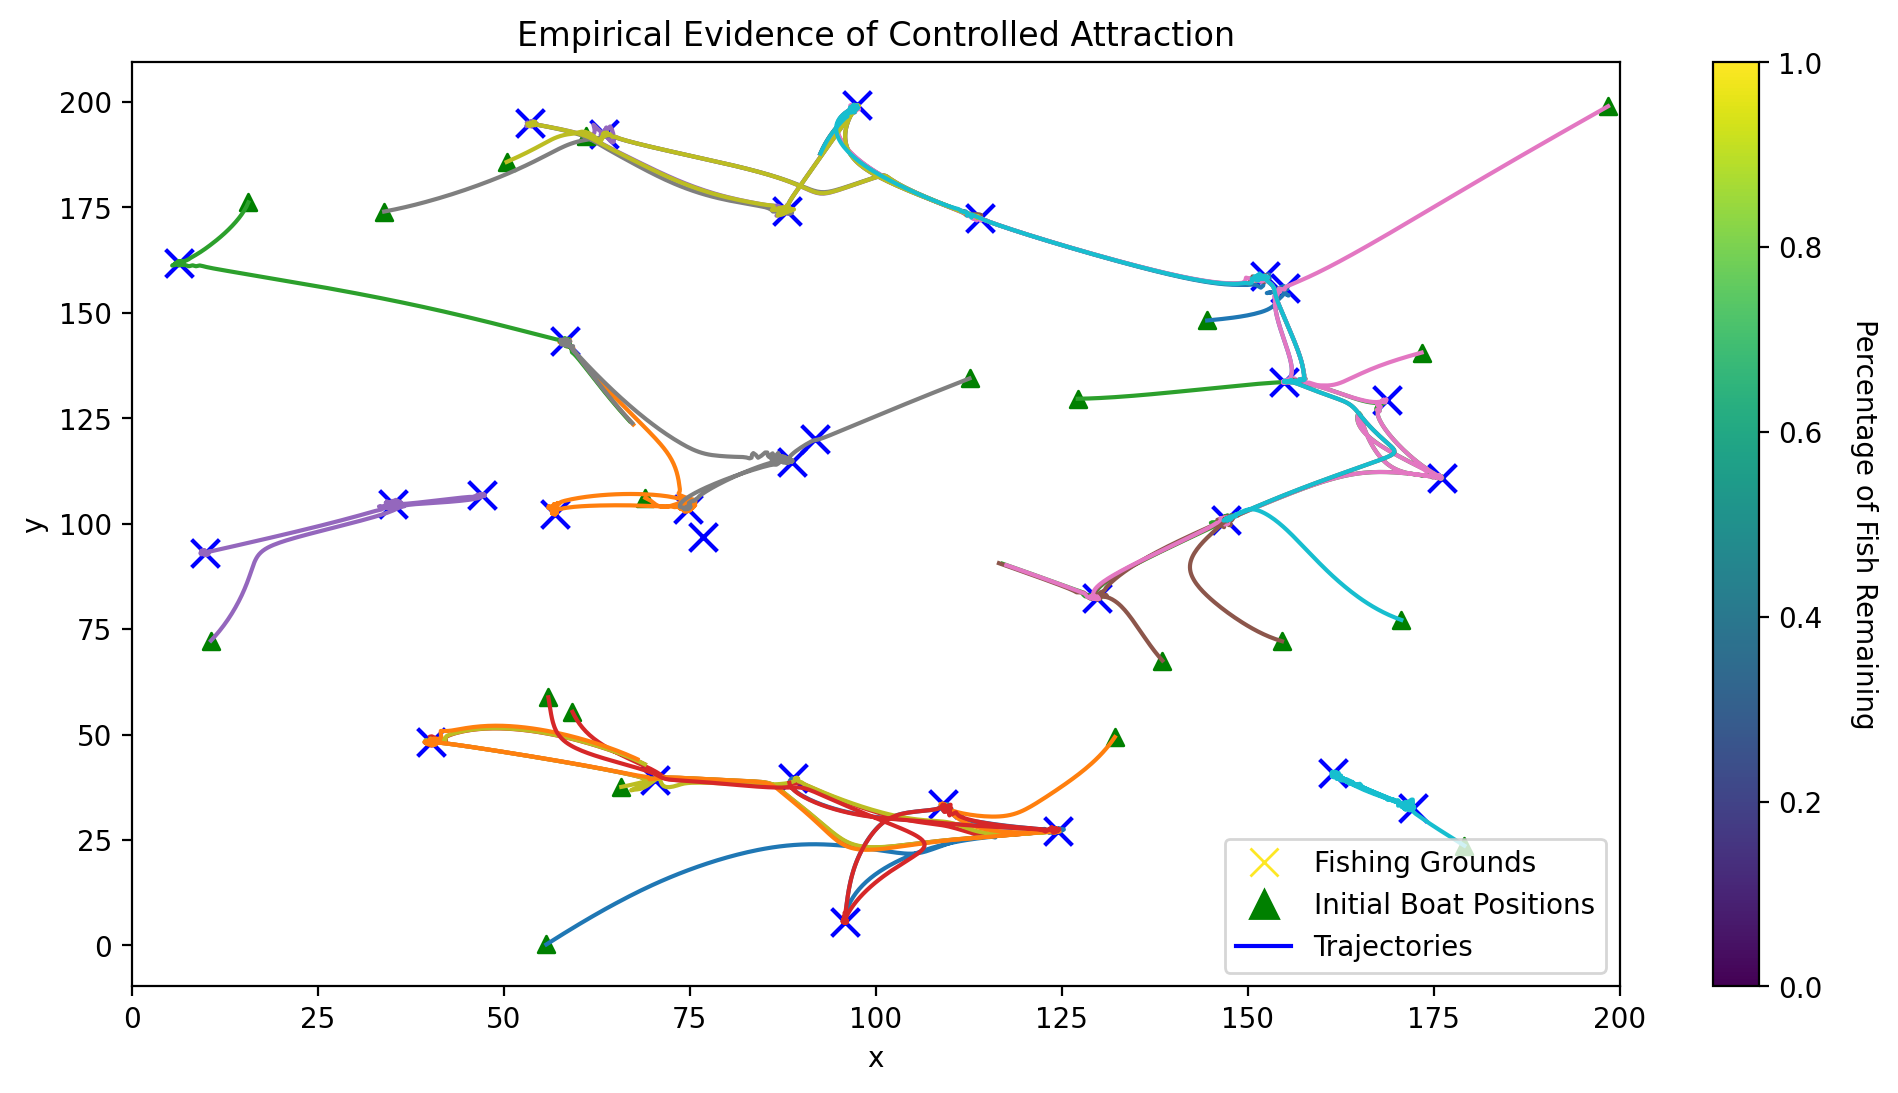

In [ ]:
#OUTDATED
alpha = .001
sigma = .01
beta = 1
rate = .01

x_max, y_max = 200, 200
n_ships = 20
n_grounds = 30
t_final = 500

# h is the harbor position
h = np.array([x_max / 2, 0])

grounds = generate_fishing_grounds(n_grounds, x_max, y_max)
ships = generate_ships(n_ships, x_max, y_max)
# print(ships.shape)
# ships = generate_ships_at_harbor(h, n_ships)

# put the grounds in the middle of both hemispheres

# put the ships at the harbor

# initialize U as all ones
U = np.ones((ships.shape[0], grounds.shape[0] + 2))

# initialize U with normal distribution, mean 1, std 0.1
U = np.random.normal(1, .25, (ships.shape[0], grounds.shape[0] + 2))
U = np.ones((ships.shape[0], grounds.shape[0] + 2))

# set the last column of U to 0
U[:,-2] = 0
U[:,-1] = .5

# initialize F as all ones
F = np.ones(grounds.shape[0])

# x is ship positions
x = ships



# Get the sizes of x and F before flattening
x_size = np.prod(x.shape)
x_shape = x.shape
F_size = np.prod(F.shape)

# Get the original shape of x

# Flatten x and F into a single 1D array
y0 = np.concatenate((x.flatten(), F))



state_params = (alpha, sigma, beta, rate, U, grounds, h, x_size, F_size, x_shape)

y_sol = solve_ivp(state, [0, t_final], y0, args=(state_params,), t_eval=np.linspace(0, t_final, t_final))

# Extract ship positions from the solution
x = y_sol.y[:x_size].reshape((n_ships, 2, -1))

# Extract F values from the solution
F = y_sol.y[x_size:x_size+F_size].T



# initialize p
p_init = np.full((n_ships, 2), 100)

# initialize pf, same size as F
pf_init = np.ones_like(F)
p_shape = p_init.shape
p_size = np.prod(p_init.shape)

# # Flatten p and pf into a single 1D array
# p0 = np.concatenate((p_init.flatten(), pf_init))

# costate_params = (x, F, 0, alpha, sigma, beta, rate, U, grounds, h, p_size, F_size, p_shape)

# p_sol = solve_ivp(costate, [0, t_final], p0, args=(costate_params,), t_eval=np.linspace(0, t_final, t_final))




fig = plt.figure(figsize=(12, 6))
fig.patch.set_facecolor('none')

ax = fig.add_subplot(111)
ax.patch.set_facecolor('white')

plt.scatter(grounds[:, 0], grounds[:, 1], c='blue', marker='x', s=100, label='Fishing Grounds')

cbar = plt.colorbar()
cbar.set_label('Percentage of Fish Remaining', rotation=270, labelpad=20)

plt.scatter(x[:, 0, 0], x[:, 1, 0], c='green', marker='^')

for i in range(x.shape[0]):
    plt.plot(x[i, 0, :], x[i, 1, :])

plt.xlabel('x')
plt.ylabel('y')
plt.title('Empirical Evidence of Controlled Attraction')

plt.xlim(0, x_max)
# plt.ylim(0, y_max)

fishing_grounds = mlines.Line2D([], [], color='#fde725', marker='x', linestyle='None', markersize=10, label='Fishing Grounds')
starting_points = mlines.Line2D([], [], color='green', marker='^', linestyle='None', markersize=10, label='Initial Boat Positions')
trajectories = mlines.Line2D([], [], color='blue', marker='_', linestyle='-', markersize=10, label='Trajectories')

plt.legend(handles=[fishing_grounds, starting_points, trajectories], loc='lower right')

# plt.savefig('massive_resolution.png', transparent=True)
plt.show()

In [ ]:
# fig, ax = plt.subplots(figsize=(10, 6))
# ax.set_xlim(0, 200)
# ax.set_ylim(0, 200)
# ax.set_xlabel('x')
# ax.set_ylabel('y')
# ax.set_title('Boat Trajectories')
# # Plot the fishing grounds and harbor for reference
# scat = ax.scatter(grounds[:, 0], grounds[:, 1], c=F_normalized, cmap='viridis', label='Fishing Grounds', marker='x', s=100)

# # Add colorbar
# cbar = plt.colorbar(scat)
# cbar.set_label('Percentage of Fish Remaining', rotation=270, labelpad=20)
# plt.tight_layout()

# # Initialize lines for each ship, storing them in a list
# lines = [ax.plot([], [], marker='^', linestyle='-', color='green', linewidth=0.5)[0] for _ in range(ships.shape[0])]

# def init():
#     # Initialize lines
#     for line in lines:
#         line.set_data([], [])
#     return lines

# def animate(frame):
#     # Update each ship's position for the current frame
#     for i, line in enumerate(lines):
#         line.set_data(ship_positions[i, 0, frame], ship_positions[i, 1, frame])
    
#     # Update the color of the fishing grounds
#     F_current = sol.y[:, frame][x_size:x_size+F_size]
#     F_normalized_current = (F_current / np.max(F)) * 100
#     scat.set_array(F_normalized_current)
    
#     return lines

# # Create the animation
# # Create the animation
# starting_points = mlines.Line2D([], [], color='green', marker='^', linestyle='None', markersize=10, label='Boat Positions')
# ani = FuncAnimation(fig, animate, frames=ship_positions.shape[2] - 1, init_func=init, blit=True, interval=20)

# plt.legend(handles=[fishing_grounds, starting_points], loc='upper left')
# plt.close(fig)

# # Display the animation
# HTML(ani.to_jshtml())

In [ ]:
# # save the animation as gif
# ani.save('visualizations/boat_trajectories.gif', fps=30)